share link https://drive.google.com/file/d/1xe4B81cNjAJXl1onZvXcjyxzKdz4NI-r/view?usp=sharing


#Description du projet
Vous êtes Data Scientist au sein de l’entreprise "Place de marché”, qui souhaite lancer une marketplace e-commerce.

Sur la place de marché, des vendeurs proposent des articles à des acheteurs en postant une photo et une description.

Pour l'instant, l'attribution de la catégorie d'un article est effectuée manuellement par les vendeurs et est donc peu fiable. De plus, le volume des articles est pour l’instant très petit.

Pour rendre l’expérience utilisateur des vendeurs (faciliter la mise en ligne de nouveaux articles) et des acheteurs (faciliter la recherche de produits) la plus fluide possible et dans l'optique d'un passage à l'échelle, il devient nécessaire d'automatiser cette tâche.

Linda, lead data scientist, vous demande donc d'étudier la faisabilité d'un moteur de classification des articles en différentes catégories, avec un niveau de précision suffisant.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
pip install nltk==3.6.1

In [ ]:
pip install opencv-python==4.5.1.48

In [ ]:
nltk.__version__, cv.__version__

('3.6.1', '4.5.1')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
from collections import defaultdict

from sklearn import manifold
from sklearn.decomposition import PCA, NMF, LatentDirichletAllocation
from sklearn.metrics import calinski_harabasz_score, silhouette_score
from sklearn.cluster import MiniBatchKMeans, KMeans, AgglomerativeClustering
from sklearn.feature_extraction.text import *
import gensim
from PIL import Image, ImageOps, ImageFilter
import cv2 as cv
import nltk
from nltk.corpus import wordnet
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
pd.set_option("display.max_columns", 150)
pd.set_option("display.max_rows", 150)
pd.set_option("display.max_colwidth", 2000)
# self library
from functions import *

In [ ]:
# import data
dir = '/content/drive/MyDrive/TechnicalLearning/Python/Jupyter/\
OC_DS_Projets/P6/Flipkart'
path1 = dir + '/flipkart_com-ecommerce_sample_1050.csv'

data = pd.read_csv(path1)

In [ ]:
data.head(2)

uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   

                                                                                                                  product_url  \
0  http://www.flipkart.com/elegance-polyester-multicolor-abstract-eyelet-door-curtain/p/itmeg7bkzdgthcts?pid=CRNEG7BKMFFYHQ8Z   
1                                  http://www.flipkart.com/sathiyas-cotton-bath-towel/p/itmegfzhxbyucwgn?pid=BTWEGFZHGBXPHZUH   

                                                 product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet Door Curtain   
1                                  Sathiyas Cotton Bath Towel   

                                                                                                                       product_category_tree  \
0                           ["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do..."]   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Sathiyas Baby Bath Towels >> Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Y..."]   

                pid  retail_price  discounted_price  \
0  CRNEG7BKMFFYHQ8Z        1899.0             899.0   
1  BTWEGFZHGBXPHZUH         600.0             449.0   

                                  image  is_FK_Advantage_product  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg                    False   
1  7b72c92c2f6c40268628ec5f14c6d590.jpg                    False   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    description  \
0  Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so that you get the rig

In [ ]:
# verify NaN values
data.isna().mean()

uniq_id                    0.000000
crawl_timestamp            0.000000
product_url                0.000000
product_name               0.000000
product_category_tree      0.000000
pid                        0.000000
retail_price               0.000952
discounted_price           0.000952
image                      0.000000
is_FK_Advantage_product    0.000000
description                0.000000
product_rating             0.000000
overall_rating             0.000000
brand                      0.321905
product_specifications     0.000952
dtype: float64

#I. Preprocessing of text

## I.i Cleaning & exploration
Text cleaning: lowercase, remove words containing digits(pure digits or mix, such as product reference.),  remove ponctuation<br>
Text exploration: number of unique words, number of total words, etc.


In [ ]:
# preprocess product description
def preprocess(text):
    # lowercase
    text_lower = text.lower()
    # remove words including digits, regex: \w*[\d]\w*
    text_digit = re.sub(r'\w*[\d]\w*', '', text_lower)
    # replace '_' with spacing
    text_special = re.sub(r'_', ' ', text_digit)
    text_clean = text_special 
    return text_clean

dscp = data['description'].apply(lambda x: preprocess(x))

In [ ]:
def corpora_freq_stat1(dscp=dscp):
    '''This function save token frequency and corpora'''
    # initialization
    corpora = defaultdict(list)
    freq = defaultdict(dict)
    total = []
    n_uniq = []
    tokenizer = nltk.RegexpTokenizer(r'\w+')
    # loop of descriptions
    for index, value in dscp.iteritems():
        tmp = tokenizer.tokenize(value)
        # save descriptions in dict: index as key, tokens list as value
        corpora[index] = tmp
        # save token frequency in dict: index as key, token freq dict as value
        freq[index] = nltk.FreqDist(tmp)
        # save list of total token size
        total.append(len(tmp))
        # save list of unique token size
        n_uniq.append(len(freq[index].keys()))
    # dataframe indicating number of unique words and number of all words
    stat = pd.DataFrame().assign(unique_words=n_uniq, total_words=total)
    return corpora, freq, stat

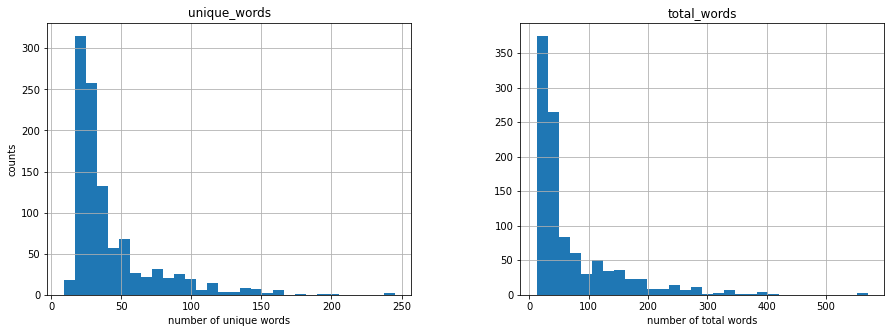

In [ ]:
# distribution of unique words and total words size in description
corpora1, freq1, stat1 = corpora_freq_stat1(dscp)
ax = stat1.hist(bins=30, figsize=(15, 5))
ax[0, 0].set(ylabel='counts', xlabel='number of unique words')
ax[0, 1].set_xlabel('number of total words')
plt.show()

Most descriptions have less than 50 unique words.<br>
Most product descriptions' length are less than 100 words.

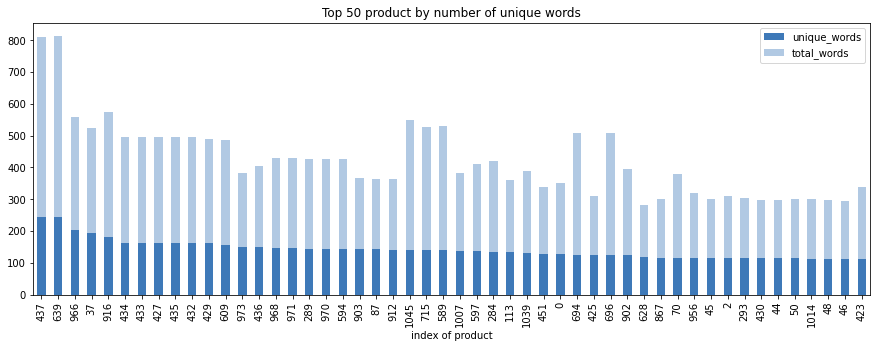

In [ ]:
# check the top50 rank by quantity of unique words
df1 = stat1.sort_values('unique_words', ascending=False)
t = 'Top 50 product by number of unique words'
c = ['#3E79B8', '#B1C9E3']
ax = df1[:50].plot(kind='bar', stacked=True, title=t, color=c, figsize=(15, 5))
ax.set_xlabel('index of product')
plt.show()

## I.ii Tokenization
tokenization and remove stopwords

In [ ]:
# compute words frequency in corpora
freq_total1 = nltk.Counter()
corpora1, freq1, stat1 = corpora_freq_stat1(dscp)
for k, v in freq1.items():
    freq_total1 += v
# select the 36 most frequent words that do not help distinguish descriptions
most_freq, _ = zip(*freq_total1.most_common(36))
# default stopwords
default = nltk.corpus.stopwords.words('english')
# sw(stopwords) = most_frequent_words + default_stopwords
sw = set()
sw.update(most_freq), sw.update(default)

In [ ]:
# check manually, then decide to remove the first 36 words
freq_total1.most_common(40)

[('of', 1751),
 ('for', 1447),
 ('the', 1369),
 ('and', 1332),
 ('to', 1058),
 ('in', 1047),
 ('rs', 911),
 ('only', 890),
 ('with', 843),
 ('on', 835),
 ('at', 714),
 ('a', 677),
 ('your', 656),
 ('is', 638),
 ('products', 631),
 ('free', 618),
 ('buy', 581),
 ('delivery', 567),
 ('genuine', 564),
 ('shipping', 564),
 ('cash', 564),
 ('replacement', 559),
 ('cm', 543),
 ('day', 540),
 ('flipkart', 481),
 ('com', 473),
 ('guarantee', 471),
 ('this', 444),
 ('it', 438),
 ('online', 396),
 ('features', 395),
 ('from', 382),
 ('specifications', 371),
 ('s', 365),
 ('you', 360),
 ('price', 352),
 ('watch', 330),
 ('color', 328),
 ('mug', 327),
 ('baby', 320)]

In [ ]:
def corpora_freq_stat2(dscp=dscp, stopword=sw):
    '''This function tokenize text and remove stopwords'''
    corpora = defaultdict(list)
    freq = defaultdict(dict)
    total = []
    n_uniq = []
    tokenizer = nltk.RegexpTokenizer(r'\w+')
    for index, value in dscp.iteritems():
        tokens = tokenizer.tokenize(value)
        # remove defaut stopwords and most common words
        tmp_sw = [w1 for w1 in tokens if not w1 in stopword]
        # remove words shorter than 3 letters
        tmp = [w for w in tmp_sw if len(w)>2]
        # corpora dict: index as keys, token list as value
        corpora[index] = tmp
        # freq dict: token frequency as value
        freq[index] = nltk.FreqDist(tmp)
        # save list of token size
        total.append(len(tmp))
        # save list of unique token size
        n_uniq.append(len(freq[index].keys()))
    stat = pd.DataFrame().assign(unique_words=n_uniq, total_words=total)
    return corpora, freq, stat

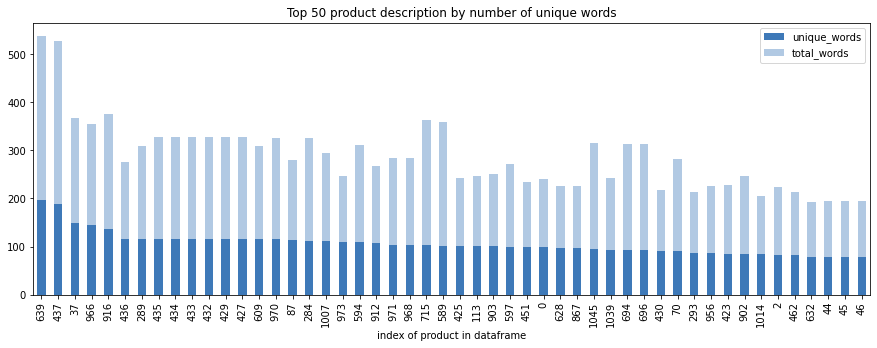

In [ ]:
# check the rank by quantity of unique words after removing stopwords
corpora2, freq2, stat2 = corpora_freq_stat2(dscp, sw)

# compute words frequency in corpora
freq_total2 = nltk.Counter()
for k, v in freq2.items():
    freq_total2 += v
    
df1 = stat2.sort_values('unique_words', ascending=False)
t = 'Top 50 product description by number of unique words'
c = ['#3E79B8', '#B1C9E3']
ax = df1[:50].plot(kind='bar', stacked=True, title=t, color=c, figsize=(15, 5))
ax.set_xlabel('index of product in dataframe')
plt.show()

There are less unique words and less total words, comparing to the previous exploration graph.

## I. iii Text Normalization
Try different methods of normalization: lemmatization, stemming or combination of the two, then choose the best way.

In [ ]:
# interpret token tags sent by pos_tag()
def get_wordnet_pos(tag):
    '''This function interpret token tags sent by pos_tag(). The result is
    assigned to argument 'pos' in wnl.lemmatize().'''
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN     # default pos-tag


# tokenization -> remove stopwords & single letter -> stemming/lemmatization
def corpora_freq_stat3(dscp=dscp, stopword=sw):
    """This function tokenize text, remove stopwords and normalize tokens"""
    stemmer = nltk.stem.snowball.EnglishStemmer()
    wnl = nltk.stem.WordNetLemmatizer()
    corpora = defaultdict(list)
    freq = defaultdict(dict)
    total = []
    n_uniq = []
    tokenizer = nltk.RegexpTokenizer(r'\w+')
    for index, value in dscp.iteritems():
        tokens = tokenizer.tokenize(value)
        # remove stopwords & words less than 3 letters
        tmp_sw = [w1 for w1 in tokens if not w1 in stopword]
        tmp_sl = [w2 for w2 in tmp_sw if len(w2)>2]
        # tag every token
        tags = nltk.pos_tag(tmp_sl)
        # lemmatization according to token tag
        tmp_lemma = [wnl.lemmatize(tag[0], pos=get_wordnet_pos(tag[1])) \
                     for tag in tags]
        # stemming
        tmp = [stemmer.stem(w) for w in tmp_lemma]
        # corpus dict: index as keys, token list as value
        corpora[index] = tmp
        # freq dict: index as keys, token freq as value
        freq[index] = nltk.FreqDist(tmp)
        # list of total token size
        total.append(len(tmp))
        # list of unique token size
        n_uniq.append(len(freq[index].keys()))
    stat = pd.DataFrame().assign(unique_words=n_uniq, total_words=total)
    return corpora, freq, stat   

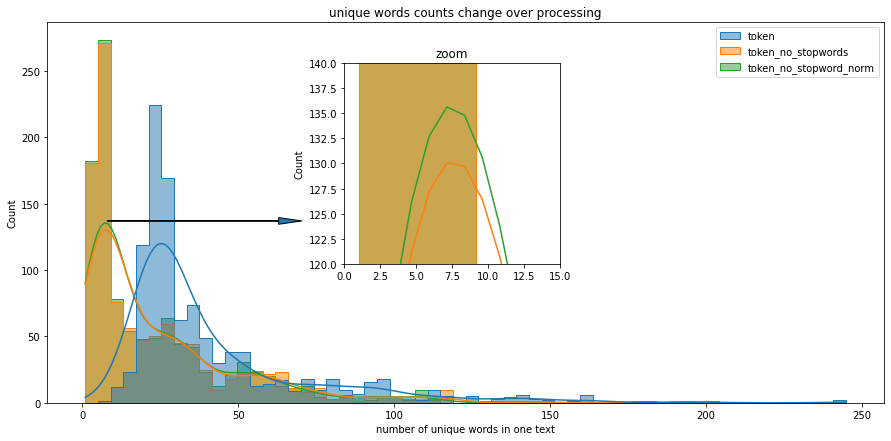

In [ ]:
corpora3, freq3, stat3 = corpora_freq_stat3(dscp)

# frequency of all description
freq_total3 = nltk.Counter()
for k, v in freq3.items():
    freq_total3 += v

# unique words change over processing
df = pd.concat([stat1['unique_words'], stat2['unique_words'],
                stat3['unique_words']], axis=1,
               keys=['token','token_no_stopwords','token_no_stopword_norm'])

fig, ax = plt.subplots(figsize=(15, 7))
sns.histplot(data=df, element='step', kde=True, ax=ax)
ax.set(title='unique words counts change over processing',
       xlabel='number of unique words in one text')
plt.arrow(8, 137, 55, 0, head_width=5)
ax2 = plt.axes([0.4, 0.4, .2, .4])
sns.histplot(df, element='step', kde=True, ax=ax2, legend=False)
ax2.set(title='zoom', xlim=[0,15], ylim=[120,140])
plt.show()

In [ ]:
# reduce dictionary's size (original -> remove stopwords -> lemmatize&stemming)
len(freq_total1.keys()), len(freq_total2.keys()), len(freq_total3.keys())

(5023, 4770, 3754)

Delete of stopwords has shift significantly the distrubution of unique_word_counts.<br>
Text normalization has reduced significantly the complexity of corpus by reduce dictionary size from 4770 to 3754.

#II Feature engineering

In [ ]:
# we've tried different ways of normalization:
# only stemming / only lemmatization / lemmatization+stemming
def tokenize_stem(text, sw=sw):
    '''This function normalize tokens by stemming'''
    stemmer = nltk.stem.snowball.EnglishStemmer()
    tokenizer = nltk.RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)
    # remove stopwords & short letter
    tmp_sw = [w1 for w1 in tokens if not w1 in list(sw)]
    tmp_sl = [w2 for w2 in tmp_sw if len(w2) > 2]
    tmp = [stemmer.stem(w) for w in tmp_sl]
    return tmp


def tokenize_lemma(text, sw=sw):
    '''This function normalize tokens by lemmatization'''
    wnl = nltk.stem.WordNetLemmatizer()
    tokenizer = nltk.RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)
    # remove stopwords & short letter
    tmp_sw = [w1 for w1 in tokens if not w1 in list(sw)]
    tmp_sl = [w2 for w2 in tmp_sw if len(w2) > 2]
    tags = nltk.pos_tag(tmp_sl)  # tag every token
    tmp = [wnl.lemmatize(tag[0], pos=get_wordnet_pos(tag[1]))\
            for tag in tags]     # lemmatize tokens according to tag
    return tmp


def lemma_stem(text, sw=sw):
    '''This function normalize tokens by lemmatization + stemming'''
    wnl = nltk.stem.WordNetLemmatizer()
    stemmer = nltk.stem.snowball.EnglishStemmer()
    tokenizer = nltk.RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)
    # remove stopwords & single letter
    tmp_sw = [w1 for w1 in tokens if not w1 in list(sw)]
    tmp_sl = [w2 for w2 in tmp_sw if len(w2) > 2]
    tags = nltk.pos_tag(tmp_sl)     # tag every token
    tmp_lemma = [wnl.lemmatize(tag[0], pos=get_wordnet_pos(tag[1]))\
                 for tag in tags]   # lemmatize tokens according to tag
    tmp = [stemmer.stem(w) for w in tmp_lemma]
    return tmp

## II.i TF-IDF

In [ ]:
def return_Xtsne(func, p=40):
    """This fuction return TSNE visualization matrix for different
    normalization function choosen."""
    tfidf = TfidfVectorizer(tokenizer=func)
    text_tfidf = tfidf.fit_transform(dscp)
    X = text_tfidf.toarray()
    tsne = manifold.TSNE(
                n_components=2,  # for projection in a plane
                perplexity=p,   # optimized perplexity
                n_iter=600,
                init='pca',  # initialisation by a PCA
                random_state=42
            )
    X_tsne = tsne.fit_transform(X)  
    return X_tsne

In [ ]:
# add category info to tsne matrix in order to evaluate performance
cat = data['product_category_tree'].apply(lambda x: re.search('"(.*)>>', x)\
                                          .group(1).split(">>")[0])
cat.name = 'main_cat'

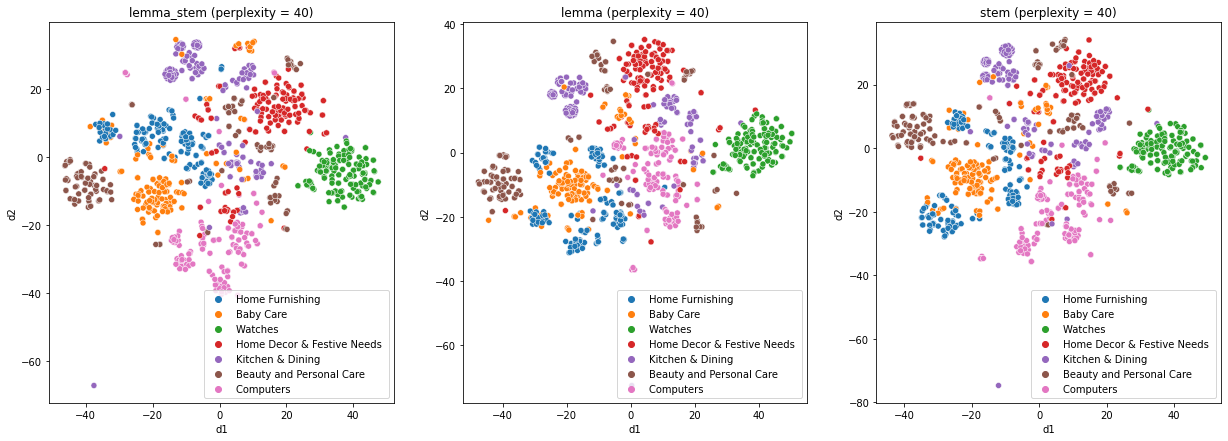

In [ ]:
# visualise tsne of different methods of normalization
dict_tsne = {}
i = 0
# dict_tsne saves TSNE matrixs applyed with different methods of normalization
for tokenizer in [lemma_stem, tokenize_lemma, tokenize_stem]:
    dict_tsne[i] = return_Xtsne(func=tokenizer)
    i+=1

# visualization
dict_df={}
for i in range(3):
    dict_df[i] = pd.concat([pd.DataFrame(dict_tsne[i], columns=['d1', 'd2']), cat],
                      axis=1)
fig, ax = plt.subplots(1, 3, figsize=(21,7))
for df_, ax_, func_ in zip(dict_df.values(), ax, ['lemma_stem', 'lemma', 'stem']):
    sns.scatterplot(data=df_, x='d1', y='d2', hue='main_cat', ax=ax_)
    ax_.set_title('{} (perplexity = 40)'.format(func_))
    ax_.legend(loc='lower right')

we'll choose lemma_stem as normalization method, since it presents a better clustering, especially for the Home Furnishing products (blue points).

## II.ii Bag of words

In [ ]:
# bag of words array
countv = CountVectorizer(tokenizer=lemma_stem)
text_counts = countv.fit_transform(dscp)

# calculate document frequency of words
bow = pd.DataFrame(text_counts.toarray(), columns=countv.get_feature_names())
doc_freq_bow = (bow>0).sum()

In [ ]:
# bag of words array
countv = CountVectorizer(tokenizer=lemma_stem)
text_counts = countv.fit_transform(dscp)

# calculate document frequency of words
bow = pd.DataFrame(text_counts.toarray(), columns=countv.get_feature_names())
# doc_freq = number of descriptions having this word
doc_freq_bow = (bow>0).sum()

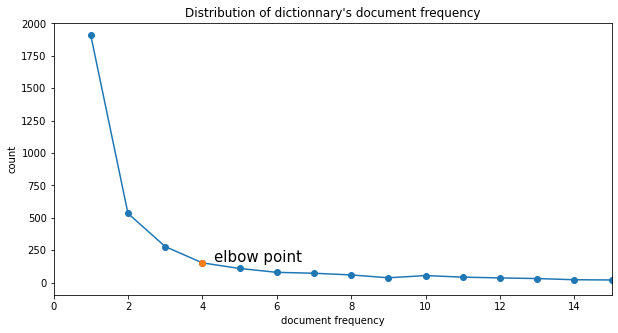

In [ ]:
# document frequency distribution
# set document frequency filter no_below = 4 (elbow point)
plt.figure(figsize=(10,5))
doc_freq_bow.value_counts().sort_index().plot(marker='o')
# mark elbow point
plt.plot(4, 152, 'o'), plt.text(4.3, 160, 'elbow point', fontsize=15)
plt.xlim(0,15), plt.xlabel('document frequency'), plt.ylabel('count')
plt.title('Distribution of dictionnary\'s document frequency')
plt.show()

Over 1800 words only appear in one document, about 500 words only appear in 2 documents, ~250 words appear in 3 documents.<br>
We can apply elbow method, remove all words which appear in less than 4 documents. This will remove 2720 words.

In [ ]:
# the most frequent words in document, doc_freq_max = 284/1500 = 18.9%
# we'll remove all word above 'watch', since they seems not valuable
# set document frequency no_above = 160
doc_freq_bow.sort_values(ascending=False)[:20]

general    284
box        251
type       237
color      235
sale       219
packag     219
number     218
best       214
brand      214
pack       213
materi     206
price      205
key        202
make       185
design     183
set        168
great      167
india      162
watch      153
model      149
dtype: int64

##II. iii Filter by document frequency

In [ ]:
# filter out 2738 word with document frequency lower than 4 and higher than 160
doc_freq_out = doc_freq_bow[(doc_freq_bow<4)|(doc_freq_bow>160)].index.tolist()
print('number of words removed by filter of doc_freq: {}'.format(
    len(doc_freq_out)))


def lemma_stem_df(text, sw=sw, df_filterout=doc_freq_out):
    """This function tokenize, normalize, remove stopwords and filter out
    extreme doc_freq words"""
    wnl = nltk.stem.WordNetLemmatizer()
    stemmer = nltk.stem.snowball.EnglishStemmer()
    tokenizer = nltk.RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)
    # remove stopwords &  2-letter words
    tmp_sw = [w1 for w1 in tokens if not w1 in list(sw)]
    tmp_sl = [w2 for w2 in tmp_sw if len(w2)>2]
    tags = nltk.pos_tag(tmp_sl)     # tag every token
    tmp_lemma = [wnl.lemmatize(tag[0], pos=get_wordnet_pos(tag[1]))\
                 for tag in tags]     # lemmatize tokens according to tag
    tmp_stem = [stemmer.stem(w) for w in tmp_lemma]
    tmp = [w3 for w3 in tmp_stem if not w3 in df_filterout]
    return tmp

number of words removed by filter of doc_freq: 2738


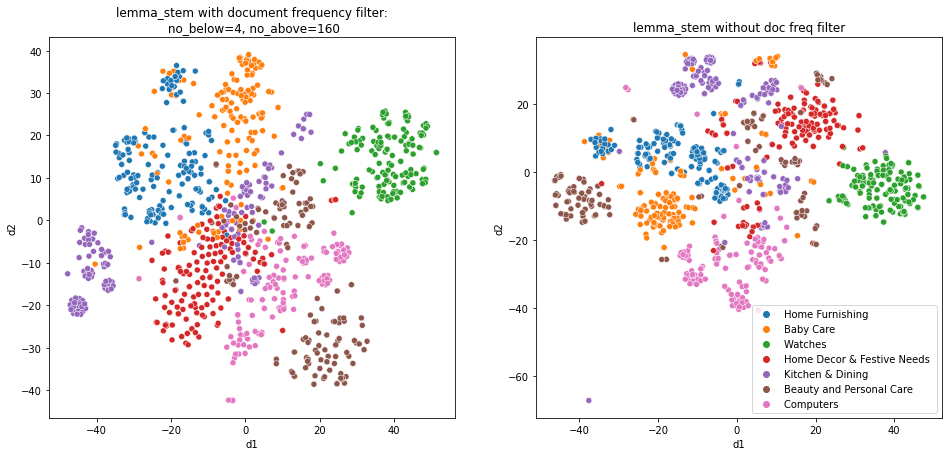

In [ ]:
# use TSNE visualization to evaluate and optimize the filter
X_tsne_df = return_Xtsne(func=lemma_stem_df, p=40)

df = pd.concat([pd.DataFrame(X_tsne_df, columns=['d1', 'd2']), cat], axis=1)
fig, ax = plt.subplots(1, 2, figsize=(16,7))
sns.scatterplot(data=df, x='d1', y='d2', hue='main_cat', ax=ax[0],
                legend=False)
ax[0].set_title('lemma_stem with document frequency filter:\n no_below=4, no_above=160')
sns.scatterplot(data=dict_df[0], x='d1', y='d2', hue='main_cat', ax=ax[1])
ax[1].set_title('lemma_stem without doc freq filter')
ax[1].legend(loc='lower right')
plt.show()

The TSNE graphe is still not bad. Meanwhile, we reduce the complexity of dictionary from 3754 unique words to 1016 unique words.

##II. iv Export data

###BOW and TFIDF

In [ ]:
# export text_tfidf, text_bagofwords filtered by document frequency
tfidf = TfidfVectorizer(tokenizer=lemma_stem_df)
text_tfidf = tfidf.fit_transform(dscp)
countv = CountVectorizer(tokenizer=lemma_stem_df)
text_bow = countv.fit_transform(dscp)
text_tfidf.shape, text_bow.shape

((1050, 1016), (1050, 1016))

In [ ]:
data_tfidf = pd.DataFrame(text_tfidf.toarray(), columns=tfidf.get_feature_names())
data_tfidf.to_feather('data_tfidf.ft')
data_bow = pd.DataFrame(text_bow.toarray(), columns=countv.get_feature_names())
data_bow.to_feather('data_bow.ft')

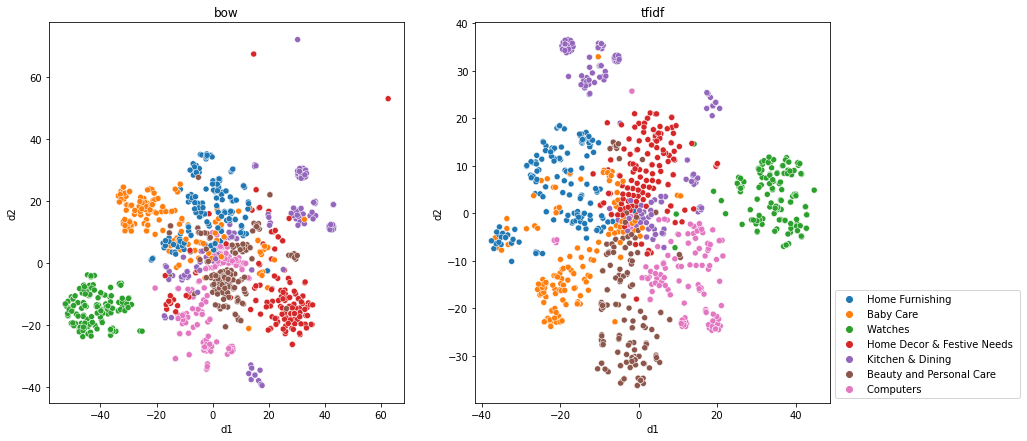

In [ ]:
# compare bow and tfidf
#data_bow = pd.read_feather('data_bow.ft')
#data_tfidf = pd.read_feather('data_tfidf.ft')
display_TSNE([data_bow, data_tfidf], title=['bow', 'tfidf'], cat=cat)

It seems that tfidf presents better than bow, especially for computers (pink points)

In [ ]:
# compare descriptions before-after
test = data['description'].iloc[16]
print(test)
print(lemma_stem(preprocess(test)), end=' ')
print(' \n')

test = data['description'].iloc[333]
print(test)
print(lemma_stem_df(preprocess(test)), end=' ')
print(' \n')


Jack klein BlackLed Digital Watch  - For Boys - Buy Jack klein BlackLed Digital Watch  - For Boys  BlackLed Online at Rs.150 in India Only at Flipkart.com. - Great Discounts, Only Genuine Products, 30 Day Replacement Guarantee, Free Shipping. Cash On Delivery!
['jack', 'klein', 'blackl', 'digit', 'watch', 'boy', 'jack', 'klein', 'blackl', 'digit', 'watch', 'boy', 'blackl', 'india', 'great', 'discount']  

Buy Binatone WR3000N only for Rs. 1800 from Flipkart.com. Only Genuine Products. 30 Day Replacement Guarantee. Free Shipping. Cash On Delivery!
[]  



In [ ]:
# verify descriptions which are empty in bag of words after preprocessing.
data[(data_bow==0).all(axis=1)]

uniq_id            crawl_timestamp  \
250  17611e6e94d73ef376834e5c6ee03dde  2015-12-01 12:40:44 +0000   
312  c20bf28cd809790c04e78fdaf47c038f  2015-12-01 06:13:00 +0000   
333  d4b625befbbb7e8004e53c187f286e11  2015-12-01 06:13:00 +0000   
352  833a87b0af3b84fe246d2ebf271af177  2015-12-01 06:13:00 +0000   
380  1eda39f01d0a8a2e5ce4b32fc7da1027  2015-12-01 06:13:00 +0000   
383  54754ccd18f2a75c53de68806176392a  2015-12-01 06:13:00 +0000   
403  b1c7aa8e0f50e7ee73ed30d12af1a961  2015-12-01 06:13:00 +0000   
413  d36e6f157d1155369f763a0a434fb129  2015-12-01 06:13:00 +0000   
452  0b8c4bc35aee94af356cb1fd2dfa0219  2015-12-03 21:49:05 +0000   

                                                                                                   product_url  \
250                                  http://www.flipkart.com/true-bong/p/itmeb467duc5fkeq?pid=BNGEB467ZXZZ4HWS   
312                                http://www.flipkart.com/intex-w150d/p/itme7ft9d98cccgs?pid=RTRE7FT9VKRGNTRR   
333                           http://www.flipkart.com/binatone-wr3000n/p/itme2tynrgeyvnh3?pid=RTRE2TYN2XUPCEVH   
352                             http://www.flipkart.com/zyxel-pla-4205/p/itmdyzydwztvmdf8?pid=RTRDYZYDXGHXXJNZ   
380                              http://www.flipkart.com/iball-wr7011a/p/itmdw77ygagzpxpt?pid=RTRDW77Y4D3QTBUG   
383                              http://www.flipkart.com/netis-wf-2301/p/itmeczandwzwyakb?pid=RTRECZANMW6UAQ5A   
403                           http://www.flipkart.com/airtel-b310s-927/p/itmed5cep6hszpfc?pid=RTRED5CEHUHGUVAH   
413                         http://www.flipkart.com/digisol-dg-bg4100n/p/itmdvfaphcq8dzpy?pid=RTRDVFAPZMNA8CHC   
452  http://www.flipkart.com/prestige-deluxe-plus-10-l-pressure-cooker/p/itmdyaqzhbqrrpjb?pid=PRCDXZP2ZFHQHUH7   

                                  product_name  \
250                                  TRUE Bong   
312                                Intex W150D   
333                           Binatone WR3000N   
352                             Zyxel PLA-4205   
380                              iBall wr7011a   
383                              Netis WF-2301   
403                           Airtel B310s-927   
413                         Digisol DG-BG4100N   
452  Prestige Deluxe Plus 10 L Pressure Cooker   

                                                                   product_category_tree  \
250                    ["Home Decor & Festive Needs >> TRUE Home Decor & Festive Needs"]   
312                      ["Computers >> Network Components >> Routers >> Intex Routers"]   
333                   ["Computers >> Network Components >> Routers >> Binatone Routers"]   
352                      ["Computers >> Network Components >> Routers >> Zyxel Routers"]   
380                      ["Computers >> Network Components >> Routers >> iBall Routers"]   
383                      ["Computers >> Network Components >> Routers >> Netis Routers"]   
403                     ["Computers >> Network Components >> Routers >> Airtel Routers"]   
413                    ["Computers >> Network Components >> Routers >> Digisol Routers"]   
452  ["Kitchen & Dining >> Pressure Cookers & Pans >> Prestige Pressure Cookers & Pans"]   

                  pid  retail_price  discounted_price  \
250  BNGEB467ZXZZ4HWS         999.0             549.0   
312  RTRE7FT9VKRGNTRR        2200.0            1350.0   
333  RTRE2TYN2XUPCEVH        2995.0            2500.0   
352  RTRDYZYDXGHXXJNZ       10999.0            8100.0   
380  RTRDW77Y4D3QTBUG        1999.0            1080.0   
383  RTRECZANMW6UAQ5A        5249.0            5249.0   
403  RTRED5CEHUHGUVAH        4999.0            2700.0   
413  RTRDVFAPZMNA8CHC        2499.0            1399.0   
452  PRCDXZP2ZFHQHUH7        2760.0            2345.0   

                                    image  is_FK_Advantage_product  \
250  17611e6e94d73ef376834e5c6ee03dde.jpg                    False   
312  c20bf28cd809790c04e78fdaf47c038f.jpg                    False   
333  

There are 9 descriptions which turned out empty in bag of words. 8 of them are too vague to be recognized. We can't even identify the product with original complet description.<br>
In practical, we need to remind their sellers to refill the description.

###PCA of BOW and TFIDF

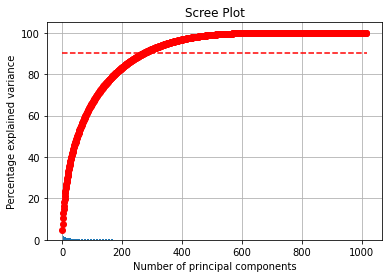

In [ ]:
pca = PCA()
pca.fit(data_tfidf)
pca_ScreePlot(pca.explained_variance_ratio_, i=90)

In [ ]:
pca = PCA(n_components=0.9)
X_pca = pca.fit_transform(data_tfidf)
col = ['PC' + str(i+1) for i in range(pca.n_components_)]
PCA_tfidf = pd.DataFrame(X_pca, columns=col)
PCA_tfidf.to_feather('PCA_tfidf.ft')
print(PCA_tfidf.shape)

(1050, 272)


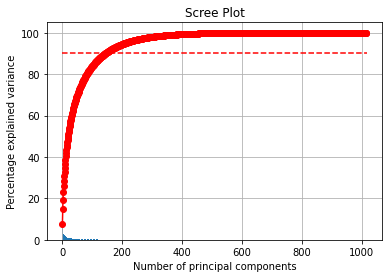

In [ ]:
pca = PCA()
pca.fit(data_bow)
pca_ScreePlot(pca.explained_variance_ratio_, i=90)

In [ ]:
pca = PCA(n_components=0.9)
X_pca = pca.fit_transform(data_bow)
col = ['PC' + str(i+1) for i in range(pca.n_components_)]
PCA_bow = pd.DataFrame(X_pca, columns=col)
PCA_bow.to_feather('PCA_bow.ft')
print(PCA_bow.shape)

(1050, 145)


###NMF

In [ ]:
def display_topics(model, feature_names, no_top_words):
    '''This function display topic with n key words'''
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx+1))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [ ]:
# optimize manually number of topics by checking their key words
n_topics=14
nmf = NMF(n_components=n_topics, random_state=42, alpha=0.1)
nmf.fit(text_tfidf)

no_top_words = 15
display_topics(nmf, tfidf.get_feature_names(), no_top_words)

Topic 1:
woman analog watch dial strap resist water discount maxima round clasp sonata case buckl gold
Topic 2:
mug ceram coffe prithish perfect gift tea printland love enjoy one get happi also bring
Topic 3:
babi girl detail fabric dress cotton boy sleev neck print ideal pattern shirt casual fit
Topic 4:
showpiec handicraft brass buddha statu ganesha gift exot decor handcraft eleph lord have lal idol
Topic 5:
combo denver playboy adida yardley deodor ice deo skin wild stone orang gift pari blue
Topic 6:
laptop batteri cell pavilion lapguard skin warranti shape mous pad rega compat adapt qualiti print
Topic 7:
towel cotton bath soft hand face absorb skin linen yellow dri luxuri marvel washabl red
Topic 8:
abstract blanket singl doubl quilt comfort multicolor raymond floral origin rajasthan dohar home blue craft
Topic 9:
rockmantra mug ceram thrill porcelain perman start stay yet creation dishwash exclus microwav craft pick
Topic 10:
usb lead light bulb power hub flexibl portabl port fa

In [ ]:
# export optimized NMF data
text_nmf = nmf.transform(text_tfidf)
col = ['topic_' + str(i+1) for i in range(nmf.n_components_)]
NMF_tfidf = pd.DataFrame(data=text_nmf, columns=col)
NMF_tfidf.to_feather('NMF_tfidf.ft')
NMF_tfidf.shape

(1050, 14)

In [ ]:
# check NMF results
data['product_category_tree'].sample(n=5, random_state=42)

352                                  ["Computers >> Network Components >> Routers >> Zyxel Routers"]
689                                       ["Kitchen & Dining >> Lighting >> Bulbs >> Philips Bulbs"]
485                           ["Computers >> Laptop Accessories >> Batteries >> Lapguard Batteries"]
388    ["Beauty and Personal Care >> Fragrances >> Deodorants >> Combos >> Anna Andre Paris Combos"]
31                                               ["Watches >> Wrist Watches >> Lenco Wrist Watches"]
Name: product_category_tree, dtype: object

In [ ]:
# NMF preforms very well on topic clustering
# product 352 has a vague description, so no topic is assigned to it
NMF_tfidf.sample(n=5, random_state=42)

topic_1   topic_2   topic_3   topic_4   topic_5   topic_6   topic_7  \
352  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
689  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
485  0.000000  0.005964  0.001545  0.000554  0.000000  0.275818  0.002392   
388  0.000000  0.000000  0.004116  0.000000  0.138625  0.000000  0.000000   
31   0.054323  0.000000  0.019839  0.000000  0.002035  0.001920  0.000000   

     topic_8   topic_9  topic_10  topic_11  topic_12  topic_13  topic_14  
352      0.0  0.000000  0.000000  0.000000  0.000000       0.0  0.000000  
689      0.0  0.000000  0.214449  0.000000  0.000000       0.0  0.000000  
485      0.0  0.008615  0.000000  0.003270  0.000000       0.0  0.015955  
388      0.0  0.000000  0.000000  0.000000  0.000072       0.0  0.005882  
31       0.0  0.008740  0.000000  0.000002  0.304771       0.0  0.000000

In [ ]:
# original description of product 352
data['description'].iloc[352]

'Buy Zyxel PLA-4205 only for Rs. 8100 from Flipkart.com. Only Genuine Products. 30 Day Replacement Guarantee. Free Shipping. Cash On Delivery!'

###LDA

In [ ]:
# LDA with text_tfidf
n_topics=12
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
text_lda = lda.fit_transform(text_tfidf)
LDA_tfidf = pd.DataFrame(text_lda, columns=['topic_'+str(i+1) for i in range(n_topics)])
LDA_tfidf.to_feather('LDA_tfidf.ft')

no_top_words = 15
display_topics(lda, tfidf.get_feature_names(), no_top_words)

Topic 1:
combo batteri laptop cell warranti lead bulb adapt denver pavilion lapguard appl cover power playboy
Topic 2:
rockmantra ceram mug combo dishwash year gift safe start fresh perman stay thrill porcelain yet
Topic 3:
mug coffe skin laptop ceram tea edimax pad one warranti shape kitchen print mous printland
Topic 4:
low tenda hair bottl spf nutcas brush wrap jewelleri hmt sunscreen play water condition vaniti
Topic 5:
showpiec inch model polyest decor sticker width brass wall eyelet curtain height dimens bodi home
Topic 6:
prithish mug ceram black pot green mom cotonex pocket ethnic otg phone glove multicolour grey
Topic 7:
babi cotton towel girl detail fabric kadhai dress bath boy print ideal sleev neck pattern
Topic 8:
mug pizza cutter glass lamp bring wheel easi qualiti duvet perfect white coffe graphic light
Topic 9:
usb router wireless link port frame hub trendnet asus light soap extend dual band kit
Topic 10:
singl quilt comfort floral bedsheet rajasthan doubl abstract doha

In [ ]:
# LDA with bag of words
n_topics=12
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
text_lda = lda.fit_transform(text_bow)
LDA_bow = pd.DataFrame(text_lda, columns=['topic_'+str(i+1) for i in range(n_topics)])
LDA_bow.to_feather('LDA_bow.ft')

no_top_words = 15
display_topics(lda, countv.get_feature_names(), no_top_words)

Topic 1:
batteri combo usb qualiti laptop cell lapguard display high may product fan hub includ pleas
Topic 2:
mug coffe ceram tea one perfect love gift printland eleg also add enjoy present serv
Topic 3:
warranti adapt laptop product cover power charger vgn vaio smartpro kadhai art qualiti custom damag
Topic 4:
beauti gather jewelleri dress cream dark lip fruit line face oxyglow net eye care vaniti
Topic 5:
showpiec wall sticker home decor brass polyest height water curtain gift gold eyelet beauti bottl
Topic 6:
hair smart phone usb otg kit plastic brown android sofa small light mobil power brush
Topic 7:
babi cotton girl fabric detail print boy towel ideal pattern sleev content neck wash dress
Topic 8:
inch cover print width cotton sheet bedsheet skin multicolor dimens model length size pillow singl
Topic 9:
mug gift ceram perfect love give rockmantra creation come detail bring year fresh dishwash size
Topic 10:
light lead usb glass power quilt comfort use flexibl bulb lamp tabl sing

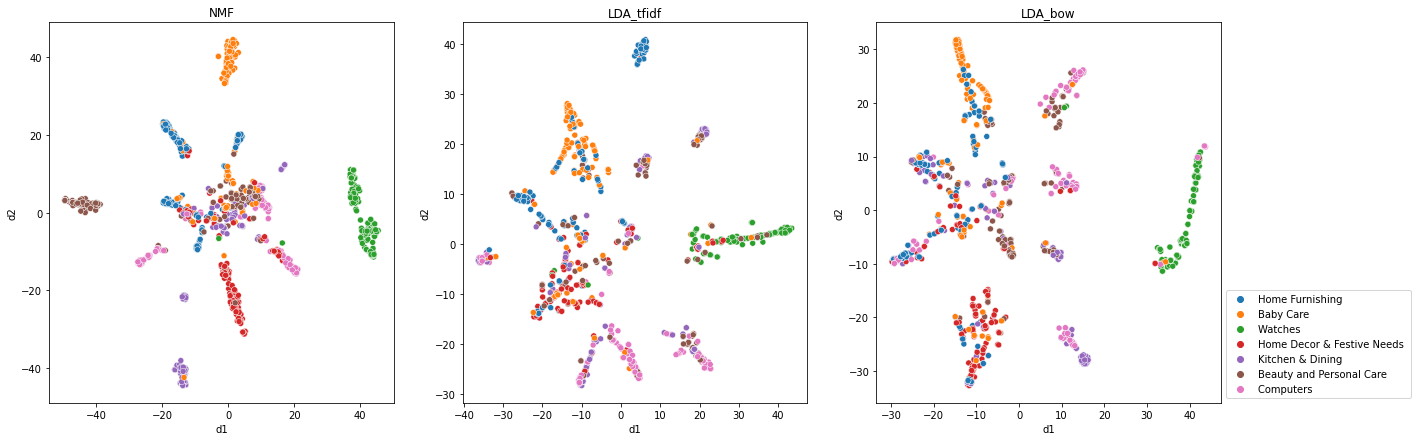

In [ ]:
display_TSNE(bof=[NMF_tfidf, LDA_tfidf, LDA_bow],
             title=['NMF', 'LDA_tfidf', 'LDA_bow'], cat=cat)

It seems that NMF presents a better clustering of topic than LDA.<br>

#III. Preprocessing of image

##III.i Resize

In [ ]:
def resize_img(img, size=(512, 512), inter=cv.INTER_AREA):
    """This function resize image without deformation. 
    The input need to be ndarray"""
    h, w = img.shape[:2]
    
    if h == w: return cv.resize(img, size, inter)
    dif = h if h > w else w
    # position where to fill original image
    x_pos = (dif - w)//2
    y_pos = (dif - h)//2
    
    if len(img.shape)==2: #gray image
        mask = np.full((dif, dif), fill_value=255, dtype=img.dtype)
        mask[y_pos:y_pos+h, x_pos:x_pos+w] = img[:h, :w]
        
    else: # RGB or else
        mask = np.full((dif, dif, img.shape[2]), fill_value=255, dtype=img.dtype)
        mask[y_pos:y_pos+h, x_pos:x_pos+w, :] = img[:h, :w, :]
        
    return cv.resize(mask, size, inter)

In [ ]:
dir_img = '/content/drive/MyDrive/TechnicalLearning/Python/Jupyter/\
OC_DS_Projets/P6/Flipkart/Images/'

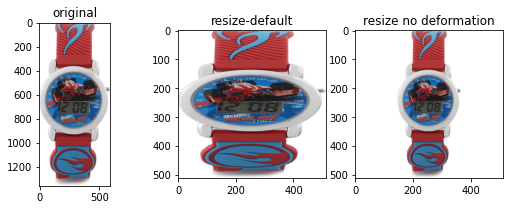

In [ ]:
# compare default resize and customized resize
img_name = data['image'].loc[544] #choose an image randomly
path = os.path.join(dir_img, img_name)
# read by open_cv, change from BGR to GRAY
img = cv.imread(path)
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
# compare original, customized-resize and default-resize images
res_default = cv.resize(img, (512, 512))
res = resize_img(img)
display_img(imgs=[img, res_default, res],
            title=['original','resize-default','resize no deformation'])

##III.ii Auto-contrast and equalization
**Auto-contrast**: Histogram stretching until the outermost gray values hit 0 and 255 respectively.<br>
**Equalization**:  flattening the grayscale histogram of an image

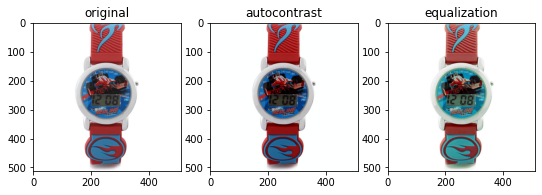

In [ ]:
im1 = Image.fromarray(res)
# remove 1% extreme lightest and darkest pixels then maximize image contrast
im2 = ImageOps.autocontrast(im1, cutoff=1)
# equalize image histogram to creat a uniform distribution of grayscale
im3 = ImageOps.equalize(im2)
display_img(imgs=[im1, im2, im3], title=['original', 'autocontrast', 'equalization'])

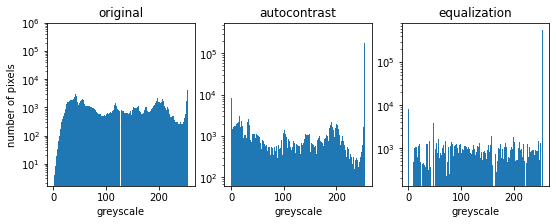

In [ ]:
# change of grayscale histogram over processing
fig, ax = plt.subplots(1, 3, figsize=(9, 3))
for img_, i, title_ in zip([im1, im2, im3], range(3),
                           ['original', 'autocontrast', 'equalization'] ):
    tmp = np.array(img_).flatten()
    ax[i].hist(tmp, bins=256, log=(0,1))
    ax[i].set(title=title_, xlabel='greyscale',
              ylabel=['number of pixels' if i==0 else None][0] )

In [ ]:
def autocontrast_equalize(img):
    """This function optimize image contrast by stretching and flattening
    image histogram.
    The input need to be ndarray"""
    tmp1 = Image.fromarray(img)
    tmp2 = ImageOps.autocontrast(tmp1, cutoff=1)
    tmp3 = ImageOps.equalize(tmp2)
    im = np.array(tmp3)
    return im

###Remove Noise

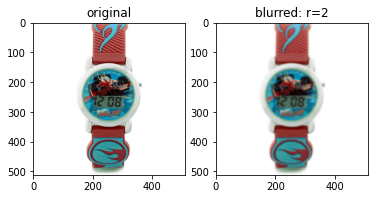

In [ ]:
im3_blur = im3.filter(ImageFilter.GaussianBlur(2))
display_img([im3, im3_blur], title=['original', 'blurred: r=2'])

### All-in-one preprocess

In [ ]:
def preprocess_img(img, size=(512, 512), theta=1):
    """This function resize image, optimize the contrast, then blur image.
    The input need to be ndarray"""
    tmp1 = resize_img(img, size)
    tmp2 = autocontrast_equalize(tmp1)
    tmp3 = Image.fromarray(tmp2)
    tmp4 = tmp3.filter(ImageFilter.GaussianBlur(radius=theta))
    img_processed = np.array(tmp4)
    return img_processed

In [ ]:
# save preprocessed images in folder
# only resize and blur
#dir_imgProAll = '/content/drive/MyDrive/TechnicalLearning/Python/Jupyter/\
#OC_DS_Projets/P6/Flipkart/processed_all_resize/'

# try radius=2
#dir_imgProAll = '/content/drive/MyDrive/TechnicalLearning/Python/Jupyter/\
#OC_DS_Projets/P6/Flipkart/processed_all_radius2/'

# try radius=1
dir_imgProAll = '/content/drive/MyDrive/TechnicalLearning/Python/Jupyter/\
OC_DS_Projets/P6/Flipkart/processed_all_radius1/'

In [ ]:
for imgname_ in data['image'].tolist():
    path_ = os.path.join(dir_img, imgname_)
    img_ = cv.imread(path_)
    #rgb_ = cv.cvtColor(img_, cv.COLOR_BGR2RGB)
    img_processed_ = preprocess_img(img_,theta=1)
    new_path_ = os.path.join(dir_imgProAll, imgname_)
    cv.imwrite(new_path_, img_processed_)

#IV Bag-of-Features

## IV.i SIFT

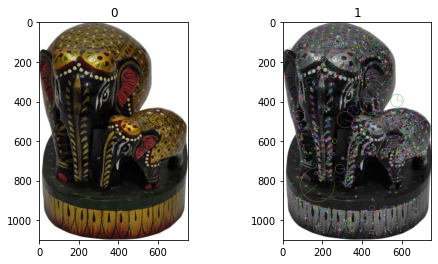

In [ ]:
# SIFT: Scale-invariant feature transform
image_name = data['image'].loc[211]
path = os.path.join(dir_img, image_name)
# use opencv read image
img = cv.imread(path)
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
sift = cv.SIFT_create()
kp = sift.detect(gray, None)
img_kp = cv.drawKeypoints(gray, kp, gray,
                          flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
display_img([img, img_kp], size=4)

### compute descriptors

In [ ]:
# compute SIFT descriptor of preprocessed images
sift = cv.SIFT_create()
des_total = []
img_all = pd.DataFrame(data['image'])
img_all['descriptor_SIFT'] = 'initial'

for index, row in img_all.iterrows():
    imgname_ = row['image']
    path_ = os.path.join(dir_imgProAll, imgname_)
    gray_ = cv.imread(path_, cv.IMREAD_GRAYSCALE)
    kp_, des_ = sift.detectAndCompute(gray_, None)
    des_total.append(des_)
    row['descriptor_SIFT'] = des_

# 1104377 descriptors for all images
des_total_arr = np.concatenate(des_total)
des_total_arr.shape

(1104377, 128)

###clustering descriptors to creat visual words
The number of clusters is visual words dictionary size.

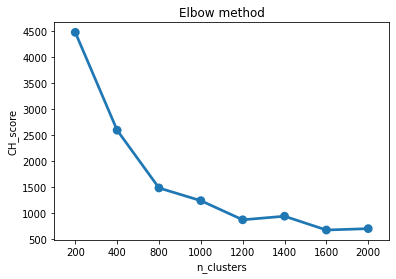

In [ ]:
# check 1104377 descriptors clustering
CH_score = {}
for k in [200, 400, 800, 1000, 1200, 1400, 1600, 2000]:
    mkmeans = MiniBatchKMeans(n_clusters=k, batch_size=100, n_init=6,
                              init_size=3000, random_state=42)
    mkmeans.fit(des_total_arr)
    CH_score[k] = calinski_harabasz_score(des_total_arr, mkmeans.labels_)
ax = sns.pointplot(x=list(CH_score.keys()), y=list(CH_score.values()))
ax.set(xlabel='n_clusters', ylabel='CH_score', title='Elbow method')
plt.show()

In [ ]:
# clustering descriptors to creat 1200 visual words
mkmeans = MiniBatchKMeans(n_clusters=1200, batch_size=300, n_init=6,
                          init_size=3000, random_state=42)
mkmeans.fit(des_total_arr)

img_all['clusters_SIFT'] = 'cluster_initial'
for indes, row in img_all.iterrows():
    des_ = row['descriptor_SIFT']
    clusters_ = mkmeans.predict(des_)
    row['clusters_SIFT'] = clusters_

# creat bag of features
bof_SIFT = defaultdict(dict)

for index, row in img_all.iterrows():
        tmp = row['clusters_SIFT']
        # normalize visual words histogram by dividing Euclidien norm
        count_ = nltk.FreqDist(tmp)
        EucliNorm_ = np.linalg.norm(np.array(list(count_.values())))
        bof_SIFT[index] = {k: count_[k]/EucliNorm_ for k in count_.keys()}


bof_SIFT = pd.DataFrame(bof_SIFT).sort_index().T.fillna(0)
bof_SIFT.columns=['clust' + str(i) for i in range(1200)]
bof_SIFT.head(3)

clust0    clust1    clust2    clust3    clust4    clust5    clust6  \
0  0.006636  0.026544  0.006636  0.006636  0.006636  0.019908  0.119449   
1  0.000000  0.000000  0.000000  0.000000  0.037871  0.000000  0.037871   
2  0.000000  0.000000  0.000000  0.017519  0.005840  0.000000  0.005840   

   clust7    clust8    clust9   clust10   clust11   clust12   clust13  \
0     0.0  0.039816  0.000000  0.019908  0.000000  0.046452  0.019908   
1     0.0  0.000000  0.037871  0.018935  0.056806  0.000000  0.000000   
2     0.0  0.000000  0.000000  0.000000  0.000000  0.017519  0.052556   

    clust14   clust15   clust16   clust17   clust18   clust19   clust20  \
0  0.026544  0.026544  0.019908  0.066361  0.019908  0.006636  0.000000   
1  0.056806  0.037871  0.000000  0.000000  0.018935  0.000000  0.018935   
2  0.000000  0.005840  0.000000  0.000000  0.005840  0.000000  0.000000   

    clust21   clust22   clust23   clust24  clust25  clust26   clust27  \
0  0.013272  0.019908  0.000000  0.026544  0.03318      0.0  0.092905   
1  0.018935  0.000000  0.132548  0.113613  0.00000      0.0  0.000000   
2  0.011679  0.023358  0.000000  0.000000  0.00000      0.0  0.000000   

    clust28   clust29  clust30   clust31   clust32   clust33   clust34  \
0  0.026544  0.013272      0.0  0.013272  0.033180  0.006636  0.000000   
1  0.000000  0.018935      0.0  0.018935  0.056806  0.000000  0.018935   
2  0.040877  0.000000      0.0  0.000000  0.000000  0.000000  0.000000   

    clust35   clust36   clust37   clust38   clust39   clust40   clust41  \
0  0.026544  0.006636  0.013272  0.006636  0.013272  0.019908  0.006636   
1  0.018935  0.000000  0.000000  0.000000  0.037871  0.018935  0.000000   
2  0.000000  0.000000  0.000000  0.005840  0.000000  0.000000  0.005840   

    clust42   clust43   clust44   clust45  clust46   clust47   clust48  \
0  0.000000  0.039816  0.053089  0.000000      0.0  0.106177  0.000000   
1  0.000000  0.018935  0.018935  0.000000      0.0  0.018935  0.018935   
2  0.017519  0.017519  0.011679  0.029198      0.0  0.000000  0.017519   

    clust49   clust50   clust51   clust52   clust53   clust54  clust55  \
0  0.006636  0.000000  0.039816  0.013272  0.000000  0.006636      0.0   
1  0.037871  0.037871  0.000000  0.000000  0.018935  0.000000      0.0   
2  0.000000  0.000000  0.005840  0.011679  0.000000  0.000000      0.0   

    clust56   clust57   clust58   clust59   clust60   clust61   clust62  \
0  0.006636  0.000000  0.046452  0.026544  0.013272  0.013272  0.053089   
1  0.000000  0.018935  0.000000  0.000000  0.000000  0.000000  0.000000   
2  0.000000  0.000000  0.005840  0.000000  0.000000  0.000000  0.005840   

    clust63   clust64   clust65   clust66  clust67   clust68   clust69  \
0  0.013272  0.013272  0.019908  0.000000      0.0  0.066361  0.000000   
1  0.000000  0.000000  0.018935  0.018935      0.0  0.037871  0.000000   
2  0.017519  0.000000  0.000000  0.070075      0.0  0.000000  0.105112   

    clust70  clust71   clust72   clust73   clust74  ...  clust1125  clust1126  \
0  0.053089      0.0  0.026544  0.019908  0.019908  ...   0.019908   0.006636   
1  0.000000      0.0  0.000000  0.000000  0.018935  ...   0.018935   0.037871   
2  0.017519      0.0  0.000000  0.000000  0.000000  ...   0.000000   0.005840   

   clust1127  clust1128  clust1129  clust1130  clust1131  clust1132  \
0   0.033180   0.000000   0.019908   0.006636   0.013272   0.019908   
1   0.000000   0.018935   0.037871   0.018935   0.000000   0.000000   
2   0.122631   0.000000   0.000000   0.000000   0.000000   0.000000   

   clust1133  clust1134  clust1135  clust1136  clust1137  clust1138  \
0        0.0   0.046452        0.0   0.000000   0.019908   0.006636   
1        0.0   0.000000        0.0   0.000000   0.000000   0.000000   
2        0.0   0.000000        0.0   0.017519   0.000000   0.000000   

   clust1139  clust1140  clust1141  clust1142  clust1143  clust1144  \
0   0.000000   0.000000   0.000000   0.013272   0.006636   0.

Text(0.5, 1.0, 'count of 1200 features')

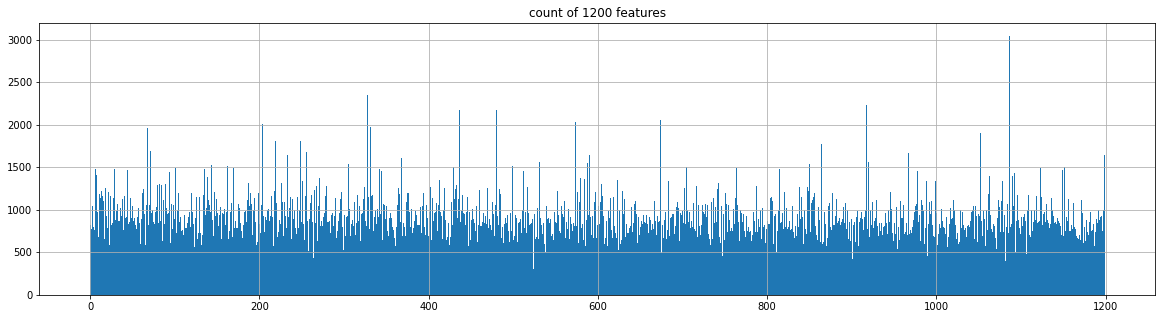

In [ ]:
# occurrence of visual words
plt.figure(figsize=(20, 5))
pd.Series(mkmeans.labels_).hist(bins=1200)
plt.title('count of 1200 features')

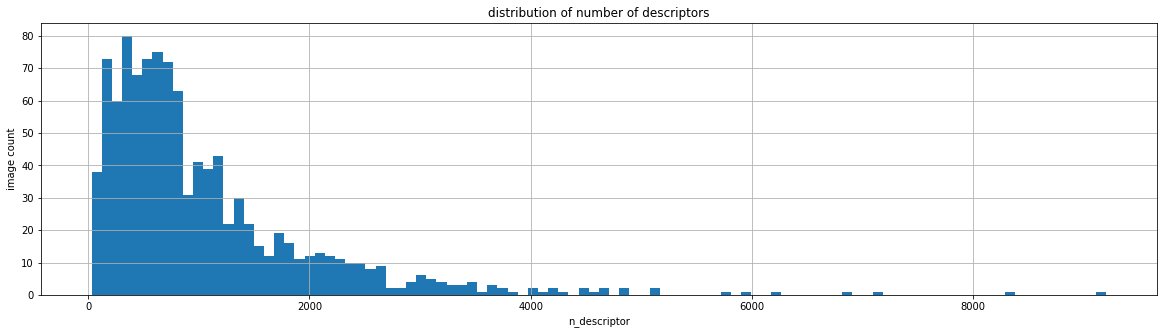

In [ ]:
# distribution of number of descriptors for images
plt.figure(figsize=(20, 5))
img_all['clusters_SIFT'].apply(lambda x: len(x)).hist(bins=100)
plt.title('distribution of number of descriptors')
plt.ylabel('image count')
plt.xlabel('n_descriptor')
plt.show()

Most images have less than 2000 descriptors. Every image has descriptors. Few images have more than 4000 descriptors.

###export bag of visual words

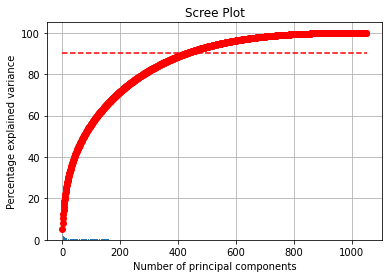

In [ ]:
pca = PCA()
pca.fit(bof_SIFT)
pca_ScreePlot(pca.explained_variance_ratio_, i=90)

In [ ]:
pca=PCA(n_components=0.9)
tmp = pca.fit_transform(bof_SIFT)
PCA_SIFT = pd.DataFrame(tmp, index=bof_SIFT.index,
                        columns=['PC'+str(i+1) for i in range(pca.n_components_)])
bof_SIFT.to_feather('bof_SIFT.ft')
PCA_SIFT.to_feather('PCA_SIFT.ft')

##IV.ii ORB

###compute descriptors

In [ ]:
# compute ORB descriptor of all preprocessed images
orb = cv.ORB_create()
des_total = []
img_all = pd.DataFrame(data['image'])
img_all['descriptor_ORB'] = 'initial'

for index, row in img_all.iterrows():
    imgname_ = row['image']
    path_ = os.path.join(dir_imgProAll, imgname_)
    img_ = cv.imread(path_, cv.IMREAD_GRAYSCALE)
    kp_, des_ = orb.detectAndCompute(img_, None)
    des_total.append(des_)
    row['descriptor_ORB'] = des_

des_total_arr_ORB = np.concatenate(des_total)
des_total_arr_ORB.shape

(510018, 32)

###creat visual words

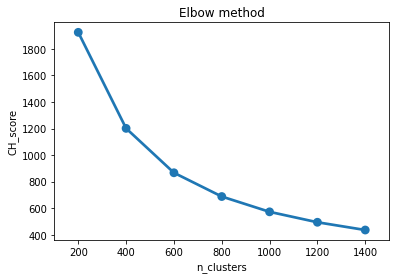

In [ ]:
# Select the best n_cluster
CH_score = {}
for k in [200, 400, 600, 800, 1000, 1200, 1400]:
    mkmeans = MiniBatchKMeans(n_clusters=k, batch_size=100, n_init=10,
                              init_size=3000, random_state=42)
    mkmeans.fit(des_total_arr_ORB)
    CH_score[k] = calinski_harabasz_score(des_total_arr_ORB, mkmeans.labels_)
ax = sns.pointplot(x=list(CH_score.keys()), y=list(CH_score.values()))
ax.set(xlabel='n_clusters', ylabel='CH_score', title='Elbow method')
plt.show()

In [ ]:
# apply the best n_cluster
mkmeans = MiniBatchKMeans(n_clusters=1200, batch_size=100, n_init=6,
                          init_size=3000, random_state=42)
mkmeans.fit(des_total_arr_ORB)

img_all['clusters_ORB'] = 'cluster_initial'
for indes, row in img_all.iterrows():
    des_ = row['descriptor_ORB']
    clusters_ = mkmeans.predict(des_)
    row['clusters_ORB'] = clusters_

# creat bag of features
bof_ORB = defaultdict(dict)

for index, row in img_all.iterrows():
        tmp = row['clusters_ORB']
        # save feature frequency(count of each feature/total features)
        count_ = nltk.FreqDist(tmp)
        EucliNorm_ = np.linalg.norm(np.array(list(count_.values())))
        bof_ORB[index] = {k: count_[k]/EucliNorm_ for k in count_.keys()}


bof_ORB = pd.DataFrame(bof_ORB).sort_index().T.fillna(0)
bof_ORB.columns=['clust' + str(i) for i in range(1200)]

###export bag of visual words

In [ ]:
pca=PCA(n_components=0.9)
tmp = pca.fit_transform(bof_ORB)
PCA_ORB = pd.DataFrame(tmp, index=bof_ORB.index,
                        columns=['PC'+str(i+1) for i in range(pca.n_components_)])
bof_ORB.to_feather('bof_ORB.ft')
PCA_ORB.to_feather('PCA_ORB.ft')

##IV.iii CNN

###VGG16, ResNet50, Xception

In [ ]:
# change manuelly source of images
# only resize
#dir_imgProAll = '/content/drive/MyDrive/TechnicalLearning/Python/Jupyter/\
#OC_DS_Projets/P6/Flipkart/processed_all_resize/'

# resize->auto contrast->blur:radius=1
dir_imgProAll = '/content/drive/MyDrive/TechnicalLearning/Python/Jupyter/\
OC_DS_Projets/P6/Flipkart/processed_all_radius1/'

In [ ]:
# change manuelly models and preprocess_input
from keras.applications.vgg16 import VGG16
#from keras.applications.vgg16 import preprocess_input
from keras.applications.resnet50 import ResNet50
#from keras.applications.resnet50 import preprocess_input
from keras.applications.xception import Xception
from keras.applications.xception import preprocess_input
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator

In [ ]:
# Change manually within VGG16, ResNet50 and Xception

#model_cnn = VGG16()
#model_cnn = ResNet50()
model_cnn = Xception()
cnn_feature = []
for imgname_ in data['image']:
    path_ = os.path.join(dir_imgProAll, imgname_)
    #img_ = load_img(path_, target_size=(224, 224)) # vgg/ResNet input size
    img_ = load_img(path_, target_size=(299, 299)) # Xception input size
    img_ = img_to_array(img_)
    img_ = img_.reshape((1, img_.shape[0], img_.shape[1], img_.shape[2]))
    img_ = preprocess_input(img_) # preprocess image as CNN model want (normalize pixel value to (-1,1))
    y = model_cnn.predict(img_)
    cnn_feature.append(y)

#bof_CNN_VGG = np.concatenate(cnn_feature)
#bof_CNN_RE = np.concatenate(cnn_feature)
bof_CNN_X = np.concatenate(cnn_feature)

In [ ]:
# VGG: (1050, 81)
pca = PCA(n_components=0.9)
X_pca = pca.fit_transform(bof_CNN_VGG)
col = ['PC' + str(i+1) for i in range(pca.n_components_)]
PCA_CNN_VGG = pd.DataFrame(X_pca, columns=col)
PCA_CNN_VGG.to_feather('PCA_CNN_VGG.ft')
bof_CNN_VGG = pd.DataFrame(bof_CNN_VGG,
                           columns=[str(i) for i in range(bof_CNN_VGG.shape[1])])
bof_CNN_VGG.to_feather('bof_CNN_VGG.ft')
print(PCA_CNN_VGG.shape)

In [ ]:
# RESNET50 (1050, 98)
pca = PCA(n_components=0.9)
X_pca = pca.fit_transform(bof_CNN_RE)
col = ['PC' + str(i+1) for i in range(pca.n_components_)]
PCA_CNN_RE = pd.DataFrame(X_pca, columns=col)
PCA_CNN_RE.to_feather('PCA_CNN_RE.ft')
bof_CNN_RE = pd.DataFrame(bof_CNN_RE,
                           columns=[str(i) for i in range(bof_CNN_RE.shape[1])])
bof_CNN_RE.to_feather('bof_CNN_RE.ft')
print(PCA_CNN_RE.shape)

In [ ]:
# Xception (1050, 71)
pca = PCA(n_components=0.9)
X_pca = pca.fit_transform(bof_CNN_X)
col = ['PC' + str(i+1) for i in range(pca.n_components_)]
PCA_CNN_X = pd.DataFrame(X_pca, columns=col)
PCA_CNN_X.to_feather('PCA_CNN_X.ft')
bof_CNN_X = pd.DataFrame(bof_CNN_X,
                           columns=[str(i) for i in range(bof_CNN_X.shape[1])])
bof_CNN_X.to_feather('bof_CNN_X.ft')
print(PCA_CNN_X.shape)

###Compare SIFT, ORB and CNN
Compare SIFT, ORB, CNN(Vgg16, ResNet50, Xception) clustering performance by TSNE


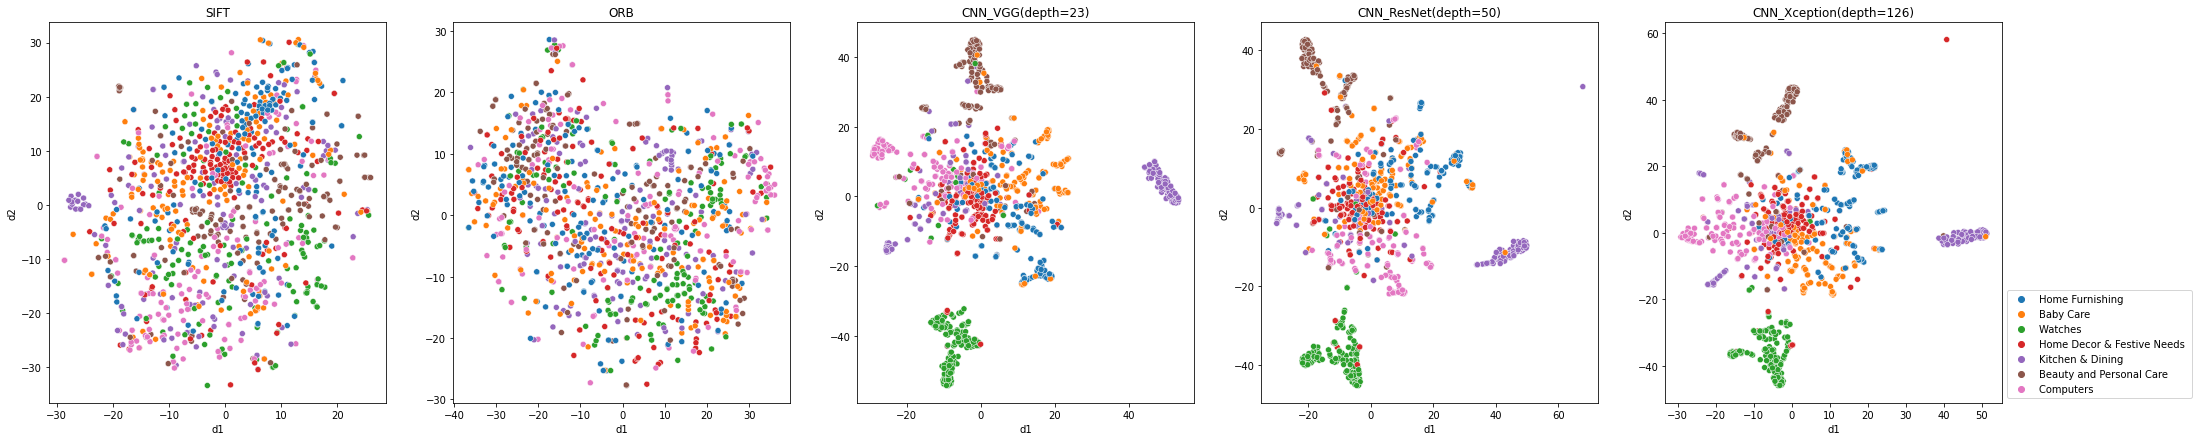

In [ ]:
bof_SIFT=pd.read_feather('bof_SIFT.ft')
bof_ORB=pd.read_feather('bof_ORB.ft')
bof_CNN_VGG=pd.read_feather('bof_CNN_VGG.ft')
bof_CNN_RE=pd.read_feather('bof_CNN_RE.ft')
bof_CNN_X=pd.read_feather('bof_CNN_X.ft')

display_TSNE(bof=[bof_SIFT, bof_ORB, bof_CNN_VGG, bof_CNN_RE, bof_CNN_X],
             title=['SIFT', 'ORB', 'CNN_VGG(depth=23)', 'CNN_ResNet(depth=50)',
                    'CNN_Xception(depth=126)'], cat=cat)

CNN algorithms work much better than SIFT and ORB.<br>
Xception, VGG16 and ResNet50 have similar performance according to TSNE visualization.

# V.Combination of text and image features

##V.i TSNE visualization of combinations
Choose the best features of text and images, then create combination of features.<br>
For text: tfidf and NMF<br>
For image: CNN_vgg16, CNN_ResNet50, CNN_Xception

In [ ]:
# choose NMF and tfidf as text features 
text_NMF = pd.read_feather('NMF_tfidf.ft').values
text_tfidf_PCA = pd.read_feather('PCA_tfidf.ft').values

# choose CNN features as image features
img_CNNvgg = pd.read_feather('PCA_CNN_VGG.ft').values
img_CNNre = pd.read_feather('PCA_CNN_RE.ft').values
img_CNNx = pd.read_feather('PCA_CNN_X.ft').values

# combination
combi = {}
i = 0
for textFeature_ in [text_NMF, text_tfidf_PCA]:
    for imgFeature_ in [img_CNNvgg, img_CNNre, img_CNNx]:
        combi[i] = np.concatenate([textFeature_, imgFeature_], axis=1)
        i+=1   

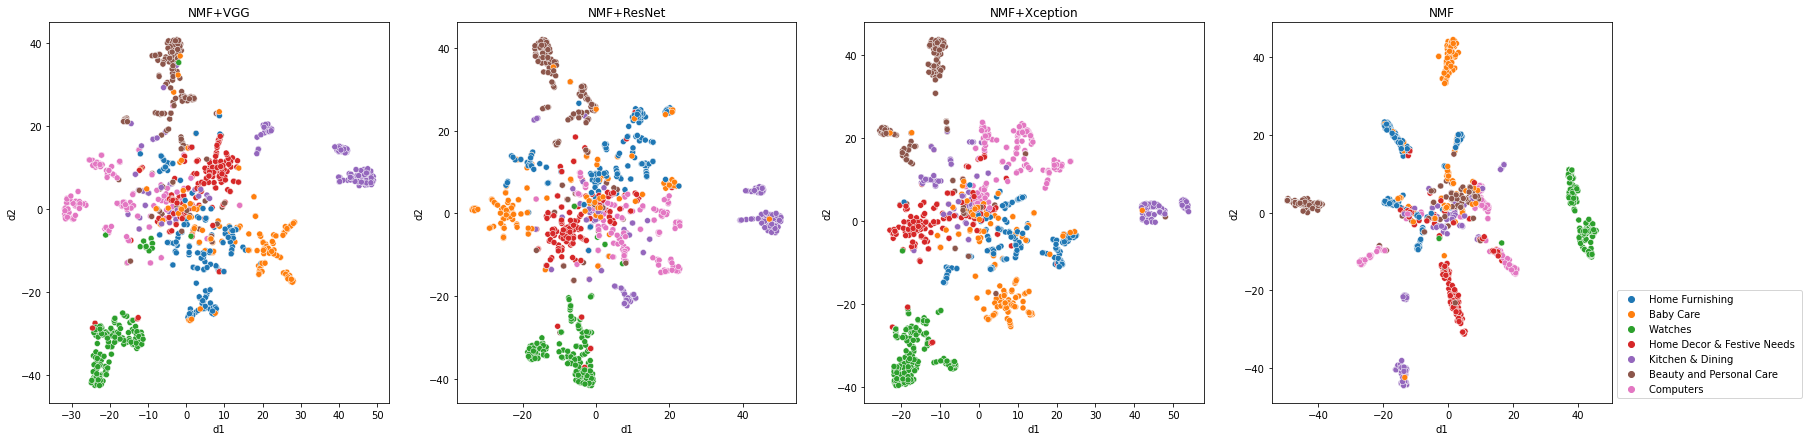

In [ ]:
# the combination of NMF and CNN, compared to only NMF
tmp = combi.copy()
tmp[3] = text_NMF
tmp1 = list(tmp.values())[0:4]
display_TSNE(bof=tmp1, title=['NMF+VGG', 'NMF+ResNet', 'NMF+Xception', 'NMF'], cat=cat)

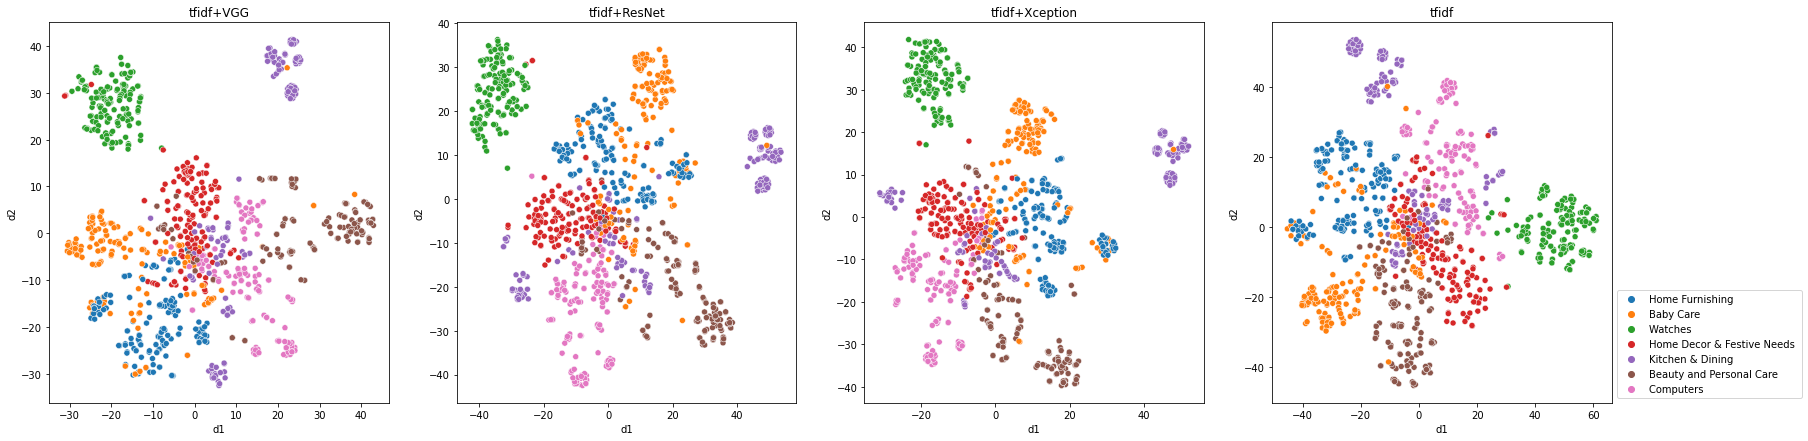

In [ ]:
# compare clustering between tfidf and tfidf+CNN
# Based on tfidf, CNN features only improve little the performance.
tmp = combi.copy()
tmp[6] = text_tfidf_PCA
tmp1 = list(combi.values())[3:7]
display_TSNE(bof=tmp1, title=['tfidf+VGG', 'tfidf+ResNet', 'tfidf+Xception', 'tfidf'], cat=cat)

According to the visualization of TSNE, we find the combination of tfidf+cnn are better than NMF+cnn. Still, we'll test all combinations' performance by hierachical clustering.

## V.ii Best combination

In [ ]:
# Looking for the best combination by using clustering hierarchical
from sklearn.model_selection import ParameterGrid
param_grid = [
              {'n_clusters': [7],
               'affinity': ['euclidean', 'manhattan', 'cosine'],
               'linkage': ['complete', 'average', 'single']},
              {'n_clusters': [7],
               'linkage': ['ward']}]
grid = ParameterGrid(param_grid)
Result={}
# best gini score of each combination
for i in range(6):
    feature = combi[i]
    gini_H = []
    for params in grid:
        hiera = AgglomerativeClustering(**params).fit(feature)
        gini_H.append(gini(hiera.labels_))
    # choose the best gini score of each combination
    Result[i] = min(gini_H)
Result

{0: 0.32326530612244897,
 1: 0.46040816326530615,
 2: 0.37170068027210884,
 3: 0.20653061224489797,
 4: 0.15836734693877552,
 5: 0.14285714285714285}

In [ ]:
# combination of best gini
feature = combi[5] # Xception+tfidf

score_H = []
params_H = []
gini_H = []
for params in grid:
    hiera = AgglomerativeClustering(**params).fit(feature)
    score_H.append(silhouette_score(feature, hiera.labels_))
    params_H.append(params)
    gini_H.append(gini(hiera.labels_))

results_H = pd.DataFrame(
    {'score': score_H, 'gini': gini_H, 'parameters': params_H})
results_H.sort_values('gini')

score      gini  \
7  0.078068  0.142857   
6  0.078016  0.418776   
9  0.102944  0.480272   
0  0.098298  0.600816   
3 -0.023977  0.762721   
4  0.013153  0.848707   
8 -0.081038  0.848707   
1  0.093491  0.849252   
2  0.063170  0.851156   
5  0.026075  0.851156   

                                                          parameters  
7      {'affinity': 'cosine', 'linkage': 'average', 'n_clusters': 7}  
6     {'affinity': 'cosine', 'linkage': 'complete', 'n_clusters': 7}  
9                               {'linkage': 'ward', 'n_clusters': 7}  
0  {'affinity': 'euclidean', 'linkage': 'complete', 'n_clusters': 7}  
3  {'affinity': 'manhattan', 'linkage': 'complete', 'n_clusters': 7}  
4   {'affinity': 'manhattan', 'linkage': 'average', 'n_clusters': 7}  
8       {'affinity': 'cosine', 'linkage': 'single', 'n_clusters': 7}  
1   {'affinity': 'euclidean', 'linkage': 'average', 'n_clusters': 7}  
2    {'affinity': 'euclidean', 'linkage': 'single', 'n_clusters': 7}  
5    {'affinity': 'manhattan', 'linkage': 'single', 'n_clusters': 7}

best score: 0.0781,
gini coefficien: 0.14, 
tbest parameter: {'affinity': 'cosine', 'linkage': 'average', 'n_clusters': 7}


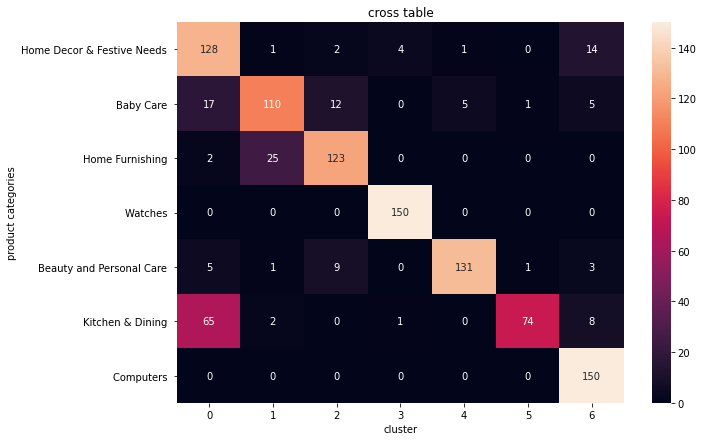

In [ ]:
i = 7 # best gini result index
hiera = AgglomerativeClustering(**params_H[i])
hiera.fit(feature)
print('best score: {:.4f},\ngini coefficien: {:.2f}, \
\ntbest parameter: {}'.format(score_H[i], gini_H[i], params_H[i]))
ct = pd.crosstab(cat, hiera.labels_)
# change order of categories to diagonize matrix for better visualization
ct_new = ct.iloc[[3,0,4,6,1,5,2]] 
plt.figure(figsize=(10,7))
ax = sns.heatmap(ct_new, annot=True, fmt='g')
ax.set(xlabel='cluster', ylabel='product categories', title='cross table')
plt.show()

Except the Kitchen & Dining Class, all others are well classified, especialy 'watches' and 'Computers'.

##V.iii Check accuracy
We can calculate global accuracy by dividing diagonal sum by total articles.<BR>
Besides, we'll check in detail some misclassified articles.

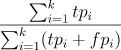

In [ ]:
# accuracy
accuracy = (128+110+123+150+131+74+150)/1050
accuracy

0.8247619047619048

In [ ]:
cat.unique()

array(['Home Furnishing ', 'Baby Care ', 'Watches ',
       'Home Decor & Festive Needs ', 'Kitchen & Dining ',
       'Beauty and Personal Care ', 'Computers '], dtype=object)

### Pseudo-misclassification
2 possibilities:
1.  These objects have properties of both categories. It's acceptable to be classified in another category.
2.  These articles are misclassified in original data and are correctly classified now.

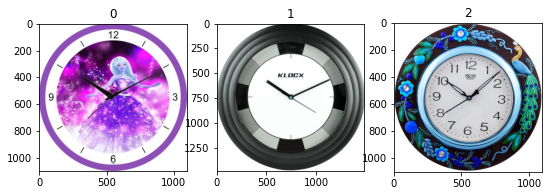

In [ ]:
# Home Decor being misclassified as watch
wrong_HomedecorToWatch = data['image'][(hiera.labels_==3)&(cat=='Home Decor & Festive Needs ')]
sample = wrong_HomedecorToWatch.sample(n=3)
wr_list = []
for imgname_ in sample:
    path_ = os.path.join(dir_img, imgname_)
    img_ = cv.imread(path_)
    wr_list.append(img_)
display_img(wr_list)

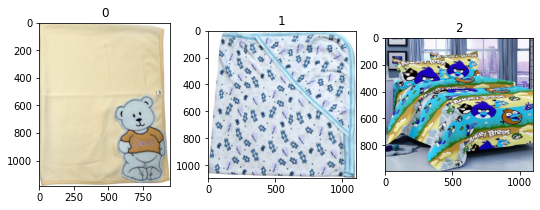

In [ ]:
# baby care misclassfied as home furnishing
# they can indeed be classified as home furnishing.
wrong_BabyToHomef = data['image'][(hiera.labels_==2)&(cat=='Baby Care ')]
sample = wrong_BabyToHomef.sample(n=3)
wr_list = []
for imgname_ in sample:
    path_ = os.path.join(dir_img, imgname_)
    img_ = cv.imread(path_)
    wr_list.append(img_)
display_img(wr_list)

###Real misclassification
errors that need to corrected

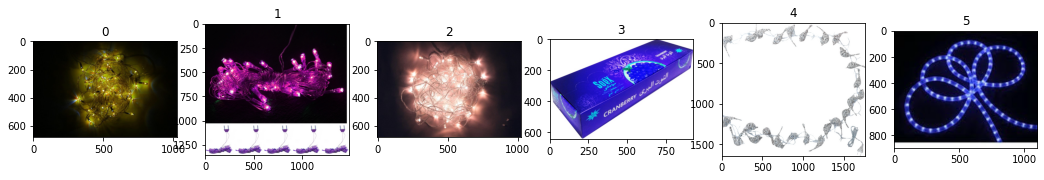

In [ ]:
# Most home Decor products misclassified in computer category are LEDs. 
# Maybe beacause there are close to routers which are equiped with LEDs. 
wrong_HomeDecorToComputer = data['image'][(hiera.labels_==6)&
                                          (cat=='Home Decor & Festive Needs ')]
sample = wrong_HomeDecorToComputer.sample(n=6)
wr_list = []
for imgname_ in sample:
    path_ = os.path.join(dir_img, imgname_)
    img_ = cv.imread(path_)
    wr_list.append(img_)
display_img(wr_list)

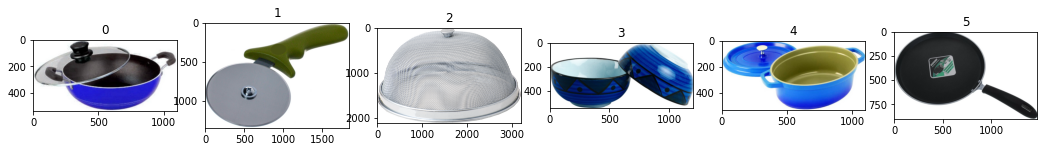

In [ ]:
# Kitchen product miclassified as home decor
wrong_KitchenToComputer = data['image'][(hiera.labels_==0)&(cat=='Kitchen & Dining ')]
sample = wrong_KitchenToComputer.sample(n=6)
wr_list = []
for imgname_ in sample:
    path_ = os.path.join(dir_img, imgname_)
    img_ = cv.imread(path_)
    wr_list.append(img_)
display_img(wr_list)

#VI.Improvement by Transfer learning
For the misclassification as above, we try to improve by transfer learning.

###Prepare data and model

In [ ]:
# Save preprocessed imgs in array
dir_imgProAll = '/content/drive/MyDrive/TechnicalLearning/Python/Jupyter/\
OC_DS_Projets/P6/Flipkart/processed_all_radius1/'

# save all preprocessed image in an array
imgs = []
for imgname_ in data['image'].tolist():
    path_ = os.path.join(dir_imgProAll, imgname_)
    img_ = load_img(path_, target_size=(224, 224)) # ResNet input size
    #img_ = load_img(path_, target_size=(299, 299)) # Xception input size
    img_ = img_to_array(img_)
    imgs.append(img_)

imgs = np.asarray(imgs)
np.save('ProcessedImages.npy', imgs)

# code catgories by number
#cat_code, uniques = pd.factorize(cat)
#np.save('cat_code.npy', cat_code)
#cat_code = np.load('cat_code.npy')

In [ ]:
# import 1050 images as array
imgs = np.load('/content/drive/MyDrive/TechnicalLearning/Python/Jupyter/OC_DS_Projets/P6/ProcessedImages.npy')
imgs.shape

(1050, 224, 224, 3)

In [ ]:
# prepare train/test data
from sklearn.model_selection import train_test_split
X = imgs
y = pd.get_dummies(cat).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((735, 224, 224, 3), (315, 224, 224, 3), (735, 7), (315, 7))

In [ ]:
# create transfer learning model
from keras.models import Model
from keras.layers import Flatten
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.layers import Dense
from keras.optimizers import SGD

# add ResNet50 pre-trained by ImageNet and remove fully-connected layers
model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

flat1 = Flatten()(model.layers[-1].output)
# Ajouter la nouvelle couche fully-connected pour la classification à 7 classes
predictions = Dense(7, activation='softmax')(flat1)

# Définir le nouveau modèle
new_model = Model(inputs=model.input, outputs=predictions)
# extraction features
for layer in model.layers:
   layer.trainable = False

new_model.compile(loss="categorical_crossentropy", optimizer=SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])

In [ ]:
new_model.layers[-1].trainable

True

In [ ]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_19[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

###Using TPUs on Colab

In [ ]:
import tensorflow as tf
#Get a handle to the attached TPU. On GCP it will be the CloudTPU itself
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
#Connect to the TPU handle and initialise it
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)

INFO:tensorflow:Initializing the TPU system: grpc://10.27.199.98:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.27.199.98:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


In [ ]:
strategy = tf.distribute.experimental.TPUStrategy(resolver)

INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


###Fitting model with original training images

In [ ]:
# Entraîner sur les données d'entraînement (X_train, y_train) 6 class(drop first)
model_info = new_model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=15, epochs=100)

Epoch 1/100
49/49 [==============================] - 17s 277ms/step - loss: 2.7377 - accuracy: 0.5055 - val_loss: 1.7544 - val_accuracy: 0.7524
Epoch 2/100
49/49 [==============================] - 10s 210ms/step - loss: 0.4270 - accuracy: 0.9320 - val_loss: 1.5461 - val_accuracy: 0.7810
Epoch 3/100
49/49 [==============================] - 10s 207ms/step - loss: 0.0303 - accuracy: 0.9870 - val_loss: 1.2968 - val_accuracy: 0.7968
Epoch 4/100
49/49 [==============================] - 10s 206ms/step - loss: 0.0120 - accuracy: 0.9934 - val_loss: 1.2662 - val_accuracy: 0.8190
Epoch 5/100
49/49 [==============================] - 10s 211ms/step - loss: 9.4700e-04 - accuracy: 1.0000 - val_loss: 1.2385 - val_accuracy: 0.8095
Epoch 6/100
49/49 [==============================] - 10s 211ms/step - loss: 2.2649e-04 - accuracy: 1.0000 - val_loss: 1.2382 - val_accuracy: 0.8095
Epoch 7/100
49/49 [==============================] - 10s 208ms/step - loss: 2.8863e-04 - accuracy: 1.0000 - val_loss: 1.2375 - v

In [ ]:
def learning_curve(loss_values, val_loss_values, accuracy, val_accuracy):
    epochs = range(1, len(loss_values) + 1)
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    #
    # Plot the model accuracy vs Epochs
    #
    ax[0].plot(epochs, accuracy, 'm', label='Training accuracy')
    ax[0].plot(epochs, val_accuracy, 'b', label='Validation accuracy')
    ax[0].set_title('Training & Validation Accuracy', fontsize=16)
    ax[0].set_xlabel('Epochs', fontsize=16)
    ax[0].set_ylabel('Accuracy', fontsize=16)
    ax[0].legend()
    #
    # Plot the loss vs Epochs
    #
    ax[1].plot(epochs, loss_values, 'm', label='Training loss')
    ax[1].plot(epochs, val_loss_values, 'b', label='Validation loss')
    ax[1].set_title('Training & Validation Loss', fontsize=16)
    ax[1].set_xlabel('Epochs', fontsize=16)
    ax[1].set_ylabel('Loss', fontsize=16)
    ax[1].legend()


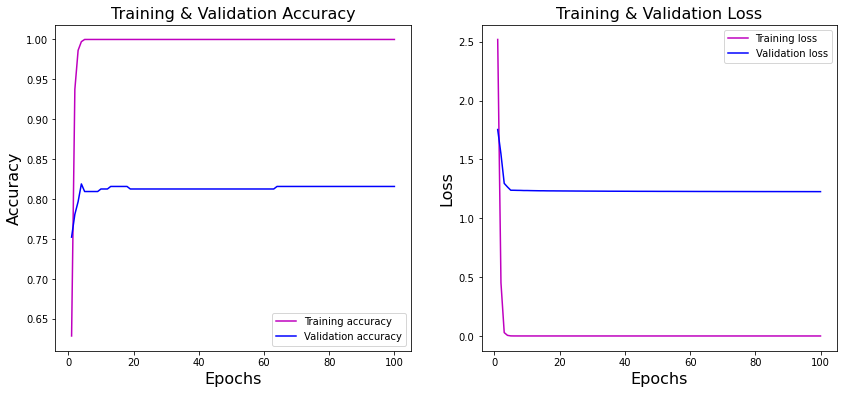

In [ ]:
# sans augmentation 1050 imgs = 735 training + 315 test
history_dict = model_info.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']
learning_curve(loss_values, val_loss_values, accuracy, val_accuracy)

After transfer learning, the accuracy of image classification is around 0.81

In [ ]:
result = new_model.predict(X_test)
from keras.metrics import CategoricalAccuracy
m = CategoricalAccuracy()
m.update_state(y_test, result)
m.result().numpy()

0.815873

In [ ]:
np.save('/content/drive/MyDrive/TechnicalLearning/Python/Jupyter/OC_DS_Projets/P6/result.npy', result)

### Data Augmentation

In [ ]:
# initialize transfer learning model
from keras.models import Model
from keras.layers import Flatten
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.layers import Dense
from keras.optimizers import SGD

# add ResNet50 pre-trained by ImageNet and remove fully-connected layers
model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

flat1 = Flatten()(model.layers[-1].output)
# Ajouter la nouvelle couche fully-connected pour la classification à 7 classes
predictions = Dense(7, activation='softmax')(flat1)

# Définir le nouveau modèle
new_model = Model(inputs=model.input, outputs=predictions)
# extraction features
for layer in model.layers:
   layer.trainable = False

new_model.compile(loss="categorical_crossentropy", optimizer=SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])

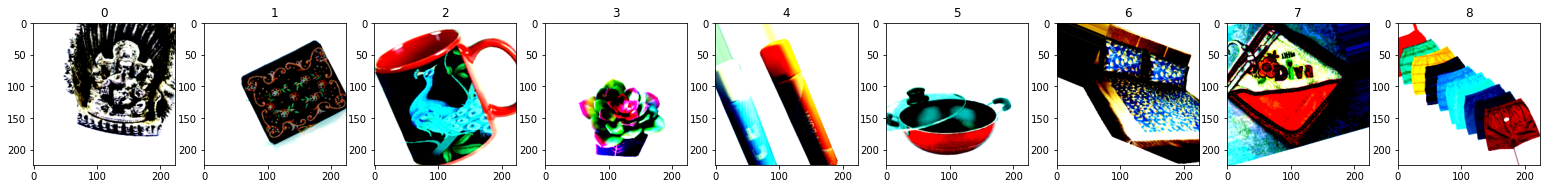

In [ ]:
# add 735 augmented images
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
datagen.fit(X_train)

data_aug = datagen.flow(X_train, y_train, batch_size=15, shuffle=False)
X_aug = []
y_aug = []
for i in range(len(data_aug)):
    X_tmp, y_tmp = data_aug.next()
    X_aug.append(X_tmp)
    y_aug.append(y_tmp)
X_aug = np.concatenate(X_aug)
y_aug = np.concatenate(y_aug)
# show augmented images
display_img(X_aug[:9])

In [ ]:
# prepare augmented training data: 735 original images + 735 augmented images
X_mixed = np.concatenate([X_train, X_aug])
y_mixed = np.concatenate([y_train, y_aug])
X_mixed.shape, y_mixed.shape
# shuffle original data with augmented data
from sklearn.utils import shuffle
X_mixed, y_mixed = shuffle(X_mixed, y_mixed, random_state=42)

In [ ]:
# fit with augmented data
model_info_aug = new_model.fit(X_mixed, y_mixed, validation_data=(X_test, y_test), batch_size=15, epochs=100)

Epoch 1/100
98/98 [==============================] - 24s 210ms/step - loss: 2.4496 - accuracy: 0.4194 - val_loss: 2.2846 - val_accuracy: 0.6825
Epoch 2/100
98/98 [==============================] - 18s 181ms/step - loss: 0.8931 - accuracy: 0.7716 - val_loss: 1.5016 - val_accuracy: 0.7937
Epoch 3/100
98/98 [==============================] - 17s 177ms/step - loss: 0.6243 - accuracy: 0.8325 - val_loss: 1.3087 - val_accuracy: 0.8127
Epoch 4/100
98/98 [==============================] - 17s 174ms/step - loss: 0.2615 - accuracy: 0.8978 - val_loss: 1.1567 - val_accuracy: 0.8286
Epoch 5/100
98/98 [==============================] - 17s 175ms/step - loss: 0.1160 - accuracy: 0.9585 - val_loss: 1.1689 - val_accuracy: 0.8286
Epoch 6/100
98/98 [==============================] - 17s 175ms/step - loss: 0.1023 - accuracy: 0.9671 - val_loss: 1.1488 - val_accuracy: 0.8159
Epoch 7/100
98/98 [==============================] - 17s 175ms/step - loss: 0.0689 - accuracy: 0.9854 - val_loss: 1.1341 - val_accuracy:

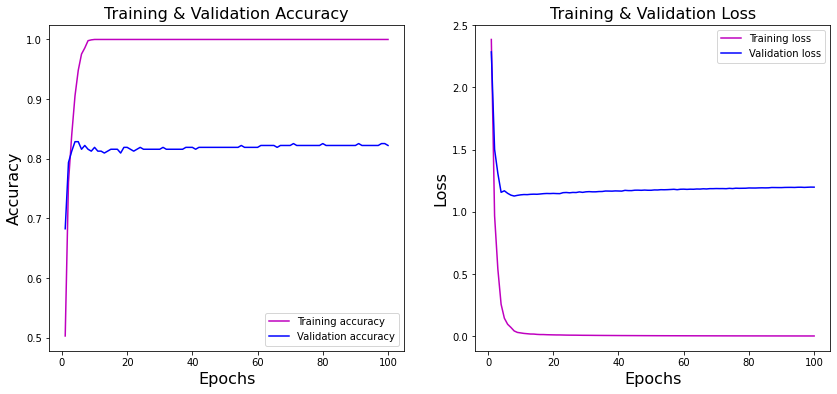

In [ ]:
history_dict = model_info_aug.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']
learning_curve(loss_values, val_loss_values, accuracy, val_accuracy)

In [ ]:
# using only image date, we are able to achieve an accuracy of 0.82
result = new_model.predict(X_test)
from keras.metrics import CategoricalAccuracy
m = CategoricalAccuracy()
m.update_state(y_test, result)
m.result().numpy()

0.82222223

By adding augmented data, there is no significant improvement on y_test prediction. The accuracy remain around 0.82. We need more real images to feed this model so as to improve its accuracy.

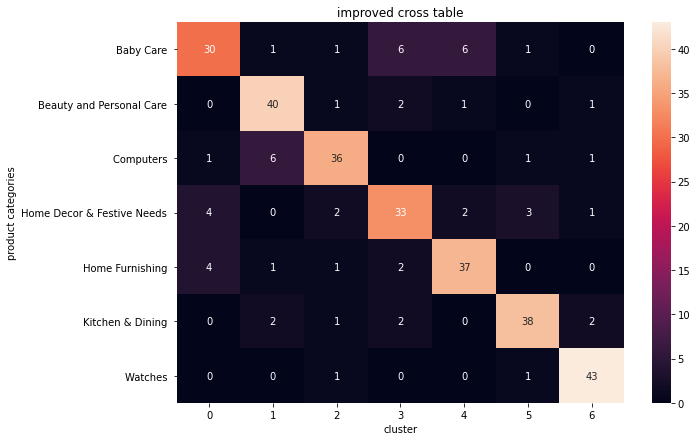

In [ ]:
# new image feature
y_pred = new_model.predict(X_test)
# cross table of new model with transfer learning (on 30% test data)
plt.figure(figsize=(10, 7))
ct = pd.crosstab(y_test.idxmax(axis=1), np.argmax(y_pred, axis=1))
ax = sns.heatmap(ct, annot=True, fmt='g')
ax.set(xlabel='cluster', ylabel='product categories', title='improved cross table')
plt.show()

Some categories can be well classifed by new image features, such as 'watches'. Some are not, we can improve it with text features.

###New combination of features
combine text NMF feature with cnn_transfer_learning features.<br>
Use only test data, which is not used for training the model.

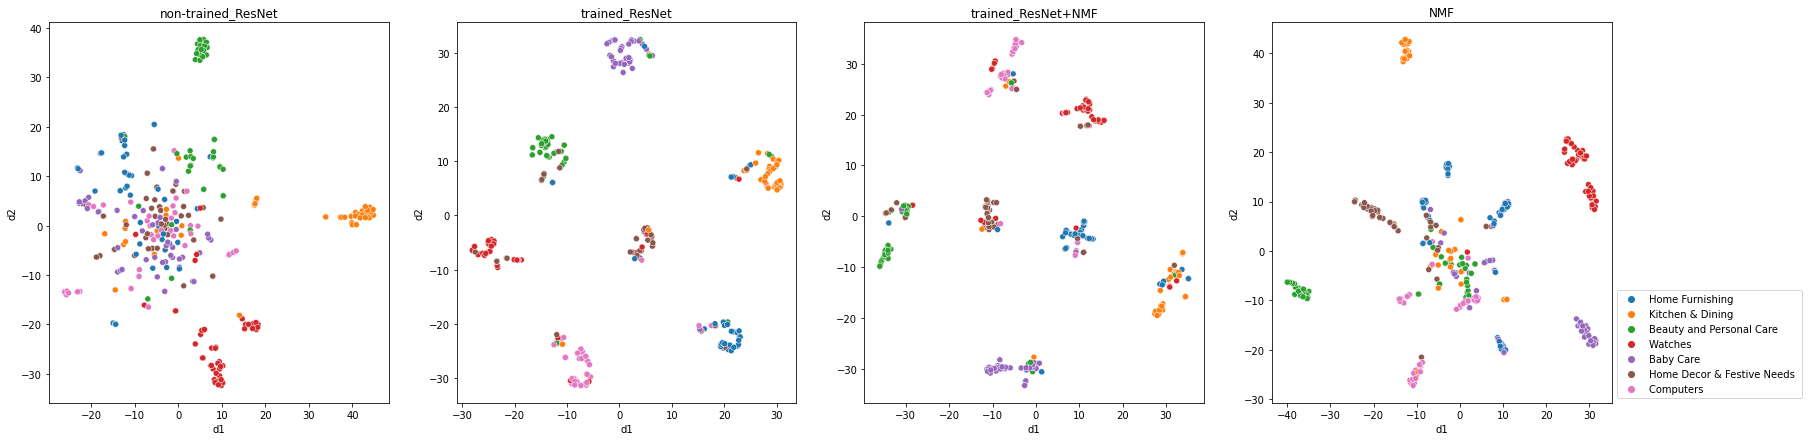

In [ ]:
# new image feature
y_pred = new_model.predict(X_test)

# corresponding text feature, non-trained ResNet feature and category
_, text_NMF_test, _, img_Res_test, _, cat_test = \
train_test_split(text_NMF, bof_CNN_RE, cat, test_size=0.3, stratify=cat, random_state=42)
print(text_NMF_test.shape, img_Res_test.shape, cat_test.shape)
# combine new text feature and new image feature
feature_test = np.concatenate((text_NMF_test.values, y_pred), axis=1)
feature_test.shape
# compare 4 clusterings: non-trained_ResNet, trained_ResNet, trained_ResNet+NMF, NMF
display_TSNE(bof=[img_Res_test, y_pred, feature_test, text_NMF_test],
             title=['non-trained_ResNet', 'trained_ResNet', 'trained_ResNet+NMF', 'NMF'],
             cat=cat_test.reset_index(), p=15)

From graphs as above, we found that:<br>
ResNet_trained is much better than non-trained_ResNet, even better than combination of its combination with NMF.<br>
For further study, we should use choose a more precise text feature extraction model, such as word embedding.

#Brouillon

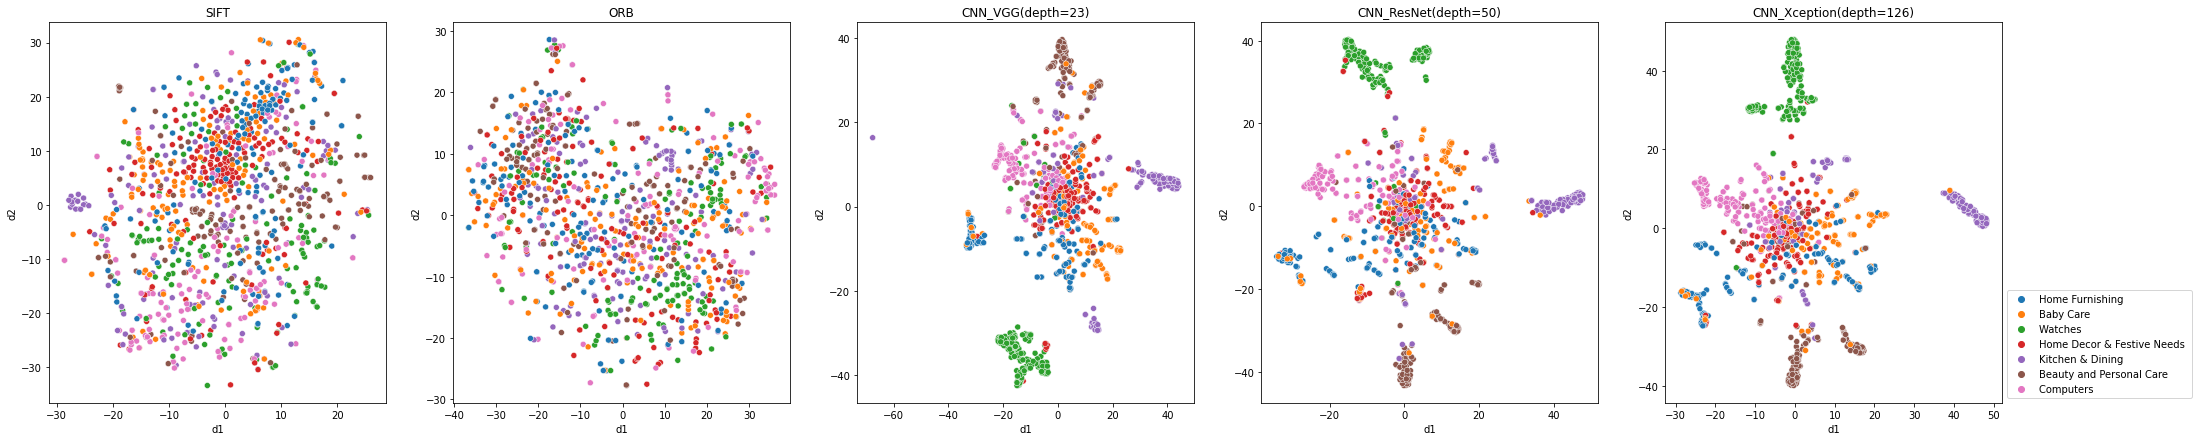

In [ ]:
# only resize and blur
bof_SIFT=pd.read_feather('bof_SIFT.ft')
bof_ORB=pd.read_feather('bof_ORB.ft')
bof_CNN_VGG=pd.read_feather('bof_CNN_VGG.ft')
bof_CNN_RE=pd.read_feather('bof_CNN_RE.ft')
bof_CNN_X=pd.read_feather('bof_CNN_X.ft')

display_TSNE(bof=[bof_SIFT, bof_ORB, bof_CNN_VGG, bof_CNN_RE, bof_CNN_X],
             title=['SIFT', 'ORB', 'CNN_VGG(depth=23)', 'CNN_ResNet(depth=50)',
                    'CNN_Xception(depth=126)'], cat=cat)

In [ ]:
# use cnn -1 layer output as features, that is 1050*100352
from keras.layers import Dense
from keras.layers import Flatten
from keras.applications.resnet50 import ResNet50
from keras.models import Model
model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
# define new model
model = Model(inputs=model.inputs, outputs=flat1)

# create cnn features for images
feature_cnn = []
for i in range(1050):
    img_ = imgs[i, ...]
    img_ = img_.reshape((1, img_.shape[0], img_.shape[1], img_.shape[2]))
    img_ = preprocess_input(img_)
    feature_cnn.append(model.predict(img_))

feature_cnn = np.concatenate(feature_cnn)
np.save('feature_cnn.npy', feature_cnn)
feature_cnn.shape

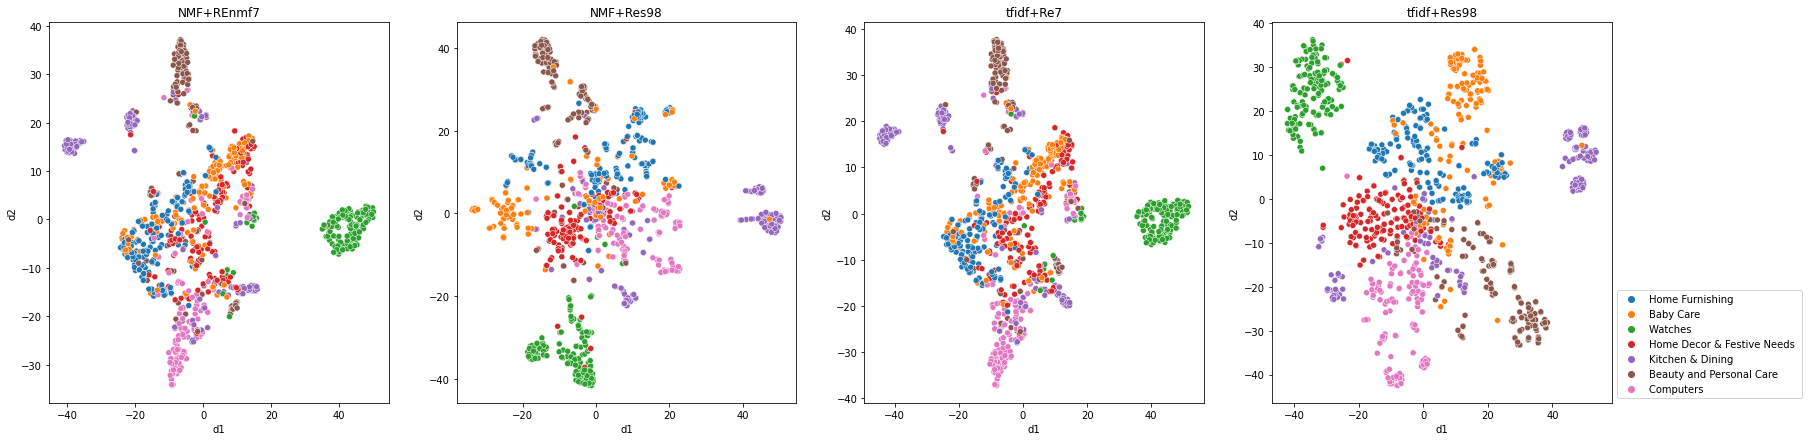

In [ ]:
# feature_cnn = np.load('/content/drive/MyDrive/TechnicalLearning/Python/Jupyter/OC_DS_Projets/P6/feature_cnn.npy')
nmf7 = NMF(n_components=7, random_state=42)
img_CNN_nmf = nmf7.fit_transform(feature_cnn)
# combination
TEST = {}
i = 0
for textFeature_ in [text_NMF, text_tfidf_PCA]:
    for imgFeature_ in [img_CNN_nmf, img_CNNre]:
        TEST[i] = np.concatenate([textFeature_, imgFeature_], axis=1)
        i+=1  

tmp = TEST.copy()
display_TSNE(bof=list(tmp.values()), title=['NMF+REnmf7', 'NMF+Res98', 'tfidf+Re7', 'tfidf+Res98'], cat=cat)

In [ ]:
# The performance of clustering is worse if we force it into 7 topics(category),
# compared to the suitable number of topics.
n_topics=7
nmf = NMF(n_components=n_topics, random_state=42, alpha=0.1)
text_NMF2=nmf.fit_transform(text_tfidf)
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
text_lda2 = lda.fit_transform(text_tfidf)

display_TSNE(bof=[NMF_tfidf, LDA_tfidf, text_NMF2, text_lda2],
             title=['NMF14topic', 'LDA_tfidf12topic', 'nmf7topic', 'lda7topic'])

In [ ]:
combi2 = {}
i = 0
for textFeature_ in [text_NMF2, text_tfidf_PCA]:
    for imgFeature_ in [img_CNNvgg, img_CNNre, img_CNNx]:
        combi2[i] = np.concatenate([textFeature_, imgFeature_], axis=1)
        i+=1   